## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the Camera Calibration using chessboard images

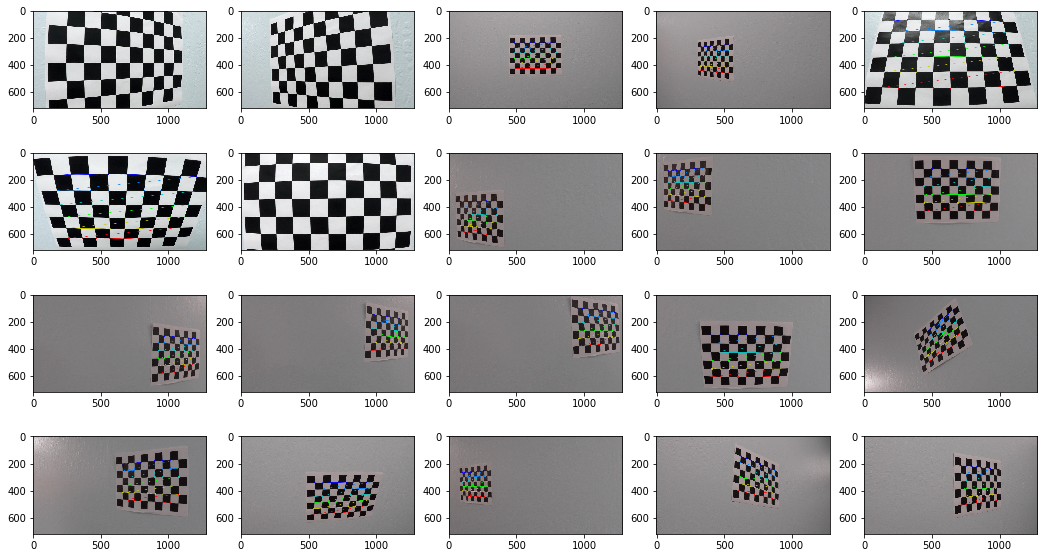

In [12]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

plt.figure(figsize=(18, 10))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    i += 1
    plt.subplot(4,5,i)
    plt.imshow(img)

plt.show()

## Let's see if it worked

In [13]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

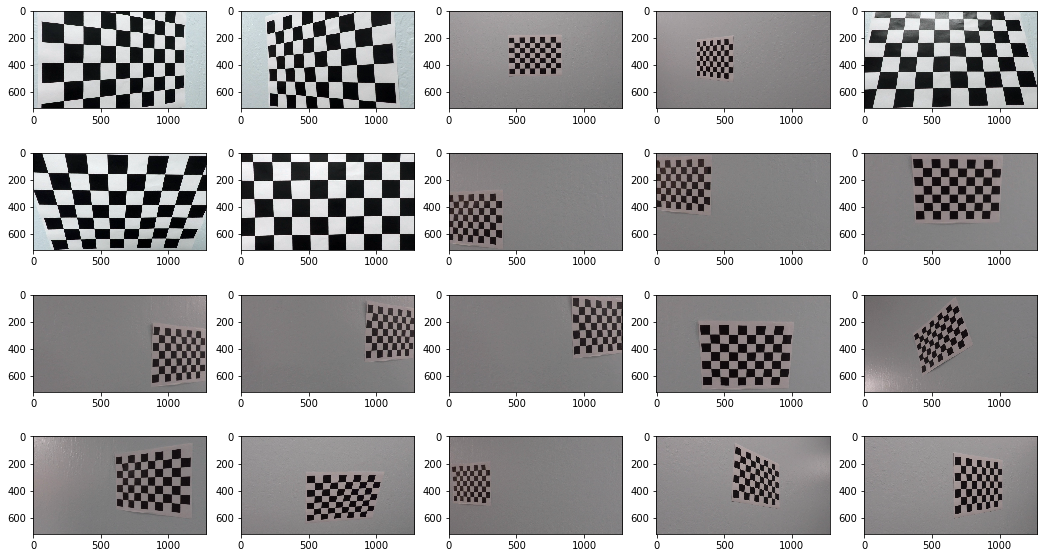

In [14]:
plt.figure(figsize=(18, 10))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    i += 1
    plt.subplot(4,5,i)
    plt.imshow(undist)

plt.show()


## Obtain Perspective Transform Matrix

863
720
(720, 1280, 3)
720
(720, 1280, 3)


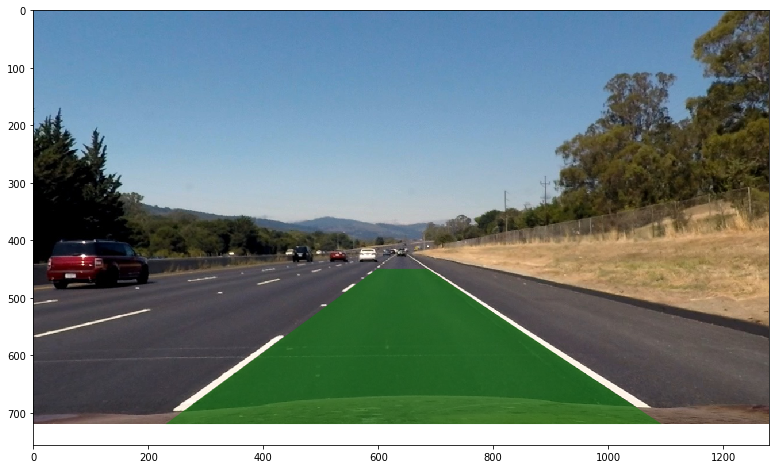

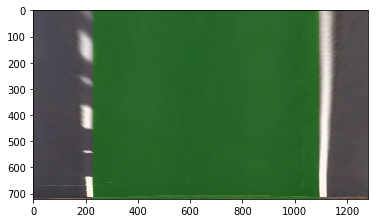

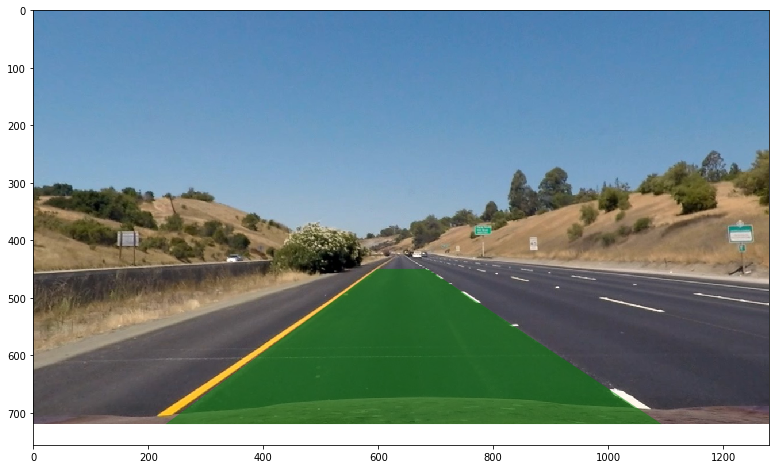

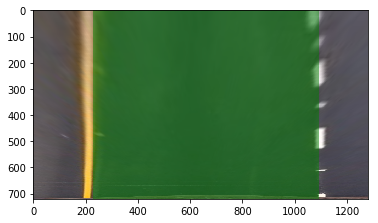

In [353]:
straight_lines_images = glob.glob('test_images/straight_lines*.jpg')

bottom_y = 720
top_y = 450

plt_width = 15

img = cv2.imread(fname)
h,w,_ = img.shape

tl = (598, top_y)
tr = (686, top_y)
bl = (230, bottom_y)
br = (1093, bottom_y)
trap = np.float32([tl, tr, br, bl])

rect_w = br[0] - bl[0]
print(rect_w)
rect_h = h
off_centre = ((br[0] + bl[0])-w)/2

tl = ((w-rect_w)/2+off_centre, 0)
tr = (w-tl[0]+2*off_centre, 0)
bl = (tl[0], rect_h)
br = (tr[0], rect_h)
rect = np.float32([tl, tr, br, bl])

M = cv2.getPerspectiveTransform(trap, rect)

for fname in straight_lines_images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    plt.figure(figsize=(plt_width, int(plt_width/w*h)))
    plt.imshow(img)
    x = [a[0] for a in trap]
    y = [a[1] for a in trap]
    plt.fill(x, y, 'g', alpha=0.5)

    print(rect_h)
    img = cv2.warpPerspective(img, M, (w, rect_h))
    print(img.shape)
    plt.figure()
    plt.imshow(img)
    x = [a[0] for a in rect]
    y = [a[1] for a in rect]
    plt.fill(x, y, 'g', alpha=0.5)
    plt.gca().set_ylim(rect_h, 0)

plt.show()

## apply transformation to test images

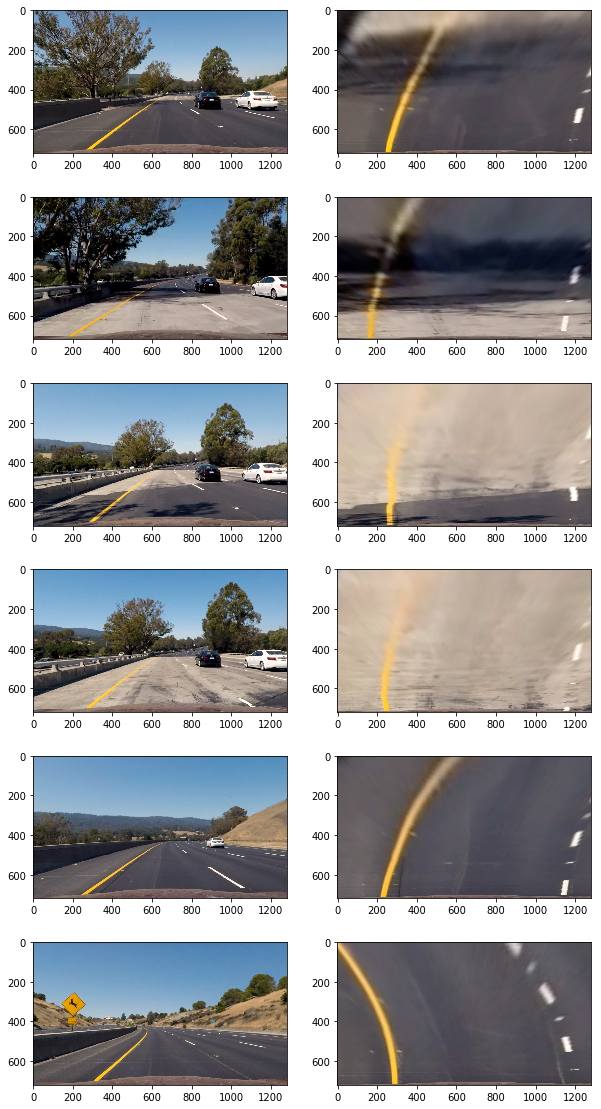

In [16]:
test_images = glob.glob('test_images/test*.jpg')

plt.figure(figsize=(10, 20))
i = 0;
for fname in test_images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    i += 1
    plt.subplot(len(test_images), 2, i)
    plt.imshow(img)

    img = cv2.warpPerspective(img, M, (w, rect_h))
    i += 1
    plt.subplot(len(test_images), 2, i)
    plt.imshow(img)

plt.show()

## Color/gradient threshold

In [128]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), sobel_kernel=3):
    thresh_min = thresh[0]
    thresh_max = thresh[1]

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
def red_select(img, thresh=(0, 255)):
    r_channel = img[:,:,2]
    binary_output = np.zeros_like(r_channel)
    binary_output[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1
    return binary_output


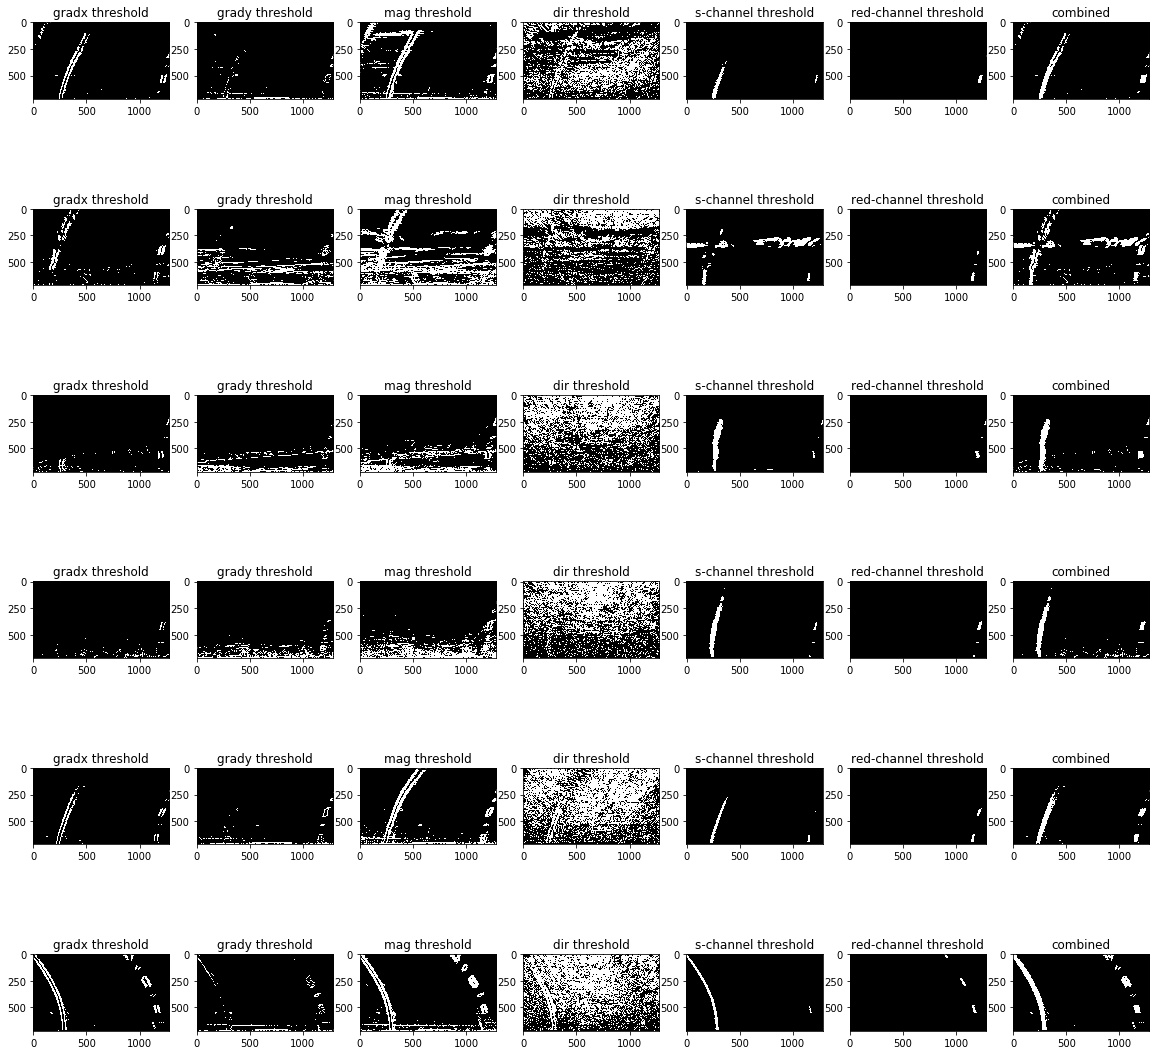

In [145]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

test_images = glob.glob('test_images/test*.jpg')

plt.figure(figsize=(20, 20))
i = 0;
for fname in test_images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img, M, (w, rect_h))

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(5, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/5))
    s_binary = hls_select(img, thresh=(140, 255))
    r_binary = red_select(img, thresh=(200, 255))
    
    total_plot = 7
    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(gradx, cmap='gray')
    plt.title("gradx threshold")

    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(grady, cmap='gray')
    plt.title("grady threshold")
    
    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(mag_binary, cmap='gray')
    plt.title("mag threshold")

    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(dir_binary, cmap='gray')
    plt.title("dir threshold")

    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(s_binary, cmap='gray')
    plt.title("s-channel threshold")

    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(r_binary, cmap='gray')
    plt.title("red-channel threshold")

    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | (s_binary == 1) | (r_binary == 1)] = 1
    i += 1
    plt.subplot(len(test_images), total_plot, i)
    plt.imshow(combined, cmap='gray')
    plt.title("combined")

plt.show()


In [136]:
def color_and_gradient_thresholding(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    s_binary = hls_select(img, thresh=(140, 255))
    r_binary = red_select(img, thresh=(200, 255))

    combined = np.zeros_like(s_binary)
    combined[(gradx == 1) | (s_binary == 1) | (r_binary == 1)] = 1
    
    return combined

In [371]:
# find pixels relatings to left and right lane lines given an image
def sliding_window_search(binary_warped, plot=False):
    # Scan bottom half of image to determine a starting point of sliding window detection
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    out_img = None
    if plot:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # assume mid point is right down middle of image
    midpoint = np.int(histogram.shape[0]/2)
    
    # find the max indicies in left and right half of the image
    leftx_base  = np.argmax(histogram[:midpoint ])
    rightx_base = np.argmax(histogram[ midpoint:]) + midpoint
    
    # from the base position, find lane lines for each window

    # Choose the number of sliding windows
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current  = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low       = binary_warped.shape[0] - (window+1)*window_height
        win_y_high      = binary_warped.shape[0] - window*window_height
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin

        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low),  (win_xleft_high,win_y_high),  (0,255,0), 4) 
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 4)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds  = ((nonzeroy >= win_y_low     ) & 
                           (nonzeroy <  win_y_high    ) & 
                           (nonzerox >= win_xleft_low ) & 
                           (nonzerox <  win_xleft_high)  ).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low      ) &
                           (nonzeroy <  win_y_high     ) & 
                           (nonzerox >= win_xright_low ) & 
                           (nonzerox <  win_xright_high)  ).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:

            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:

            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # update the line objects
    left_line.allx = leftx
    left_line.ally = lefty
    right_line.allx = rightx
    right_line.ally = righty

    if plot:
        out_img[nonzeroy[left_lane_inds],  nonzerox[left_lane_inds] ] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

In [401]:
# Define a class to receive the characteristics of each line detection
class Line():
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/rect_w # meters per pixel in x dimension
    n = 10
    margin = 150
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fitted = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def update(self, detected, current_fit):
        if detected:
            self.detected = True
            self.recent_fitted.append(current_fit)
            if len(self.recent_fitted) > self.n:
                self.recent_fitted.pop(0)
        else:
            self.detected = False
            if len(self.recent_fitted):
                self.recent_fitted.pop(0)
        
        self.update_best_fit()
    
    def fit(self, x, y):
        if len(x) and len(y):
            current_fit = np.polyfit(y*self.ym_per_pix, x*self.xm_per_pix, 2)
            self.update(True, current_fit)

    def pop(self):
        if len(self.recent_fitted):
            self.recent_fitted.pop()
            self.update_best_fit()
            
    def update_best_fit(self):
        if len(self.recent_fitted):
            self.best_fit = sum(self.recent_fitted)/len(self.recent_fitted)
        else:
            self.best_fit = None

    def evaluate(self, y):
        if self.best_fit is not None:
            x = (self.best_fit[0]*(y*self.ym_per_pix)**2 + self.best_fit[1]*(y*self.ym_per_pix) + self.best_fit[2])/self.xm_per_pix
        else:
            x = -1
        return x
    
    def get_curvature(self, y):
        if self.best_fit is not None:
            c = ((1+(2*self.best_fit[0]*y*self.ym_per_pix+self.best_fit[1])**2)**1.5)/np.absolute(2*self.best_fit[0])
        else:
            c = -1
        return c
    
    def get_mask(self, w, h):
        if len(self.recent_fitted):
            # Generate x and y values for plotting
            polyy = np.linspace(0, h)
            polyx = self.evaluate(polyy)

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([polyx-self.margin, polyy]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([polyx+self.margin, polyy])))])
            pts = np.hstack((pts_left, pts_right))

            mask = np.zeros((w, h), dtype=np.uint8)
            cv2.fillPoly(mask, np.int_(pts), 1)

            return mask
        else:
            return None


In [402]:
def sanity_check(left_line, right_line):
    y = 360
    lcur = left_line.get_curvature(y)
    rcur = right_line.get_curvature(y)
    
    # Checking that they have similar curvature
    cur_min = 195.986
    if lcur < cur_min or rcur < cur_min:
        print("curvature failed", lcur, rcur)
        return False
    
    # Checking that they are roughly parallel
    ploty = np.linspace(0, 719)
    left_fitx  = left_line.evaluate(ploty)
    right_fitx = right_line.evaluate(ploty)
    
    xdiff = right_fitx - left_fitx
    # Checking that they are separated by approximately the right distance horizontally
    if np.std(xdiff)/np.mean(xdiff) > 0.06:
        print("parallel failed", np.std(xdiff)/np.mean(xdiff))
        return False
    
    if abs(np.mean(xdiff) - rect_w)/rect_w > 0.2:
        print("separation failed")
        return False
    
    return True

test_images/test6.jpg


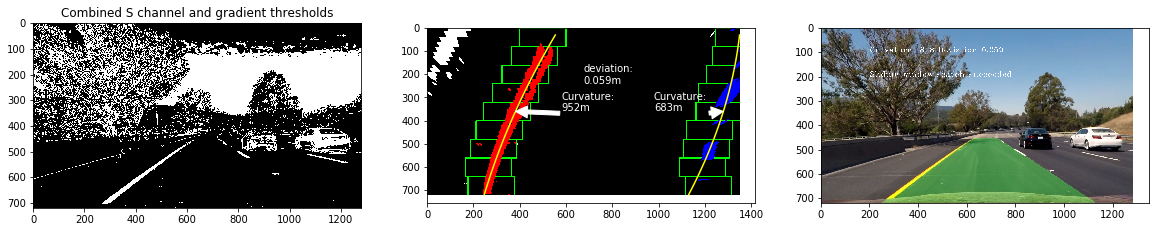

test_images/test5.jpg
parallel failed 0.126330383512


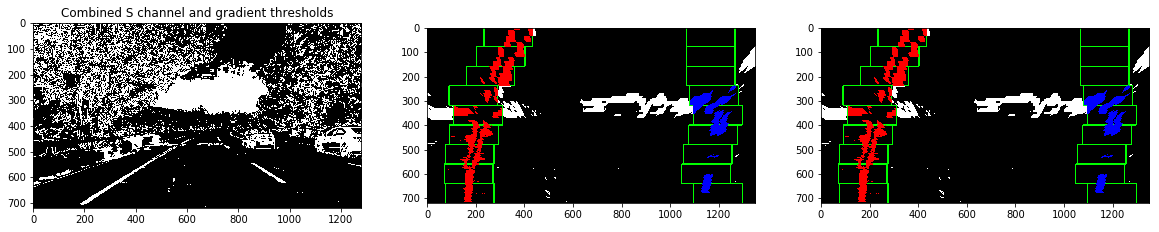

test_images/test4.jpg


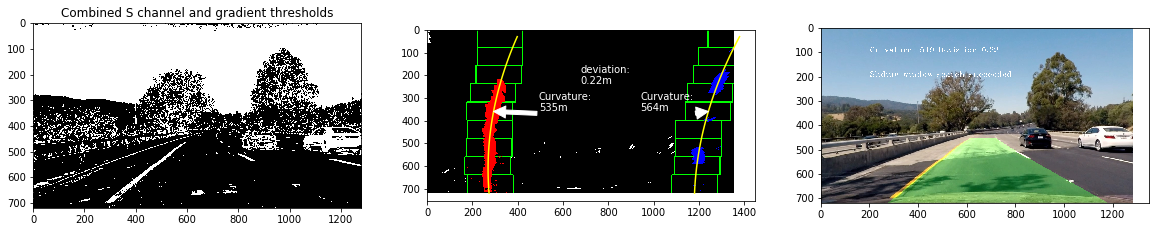

test_images/test1.jpg


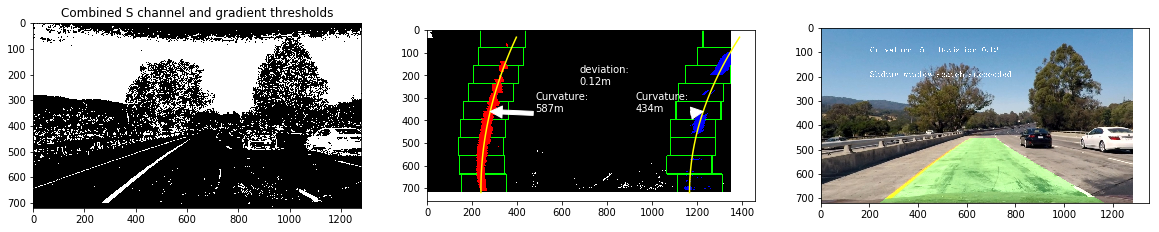

test_images/test3.jpg


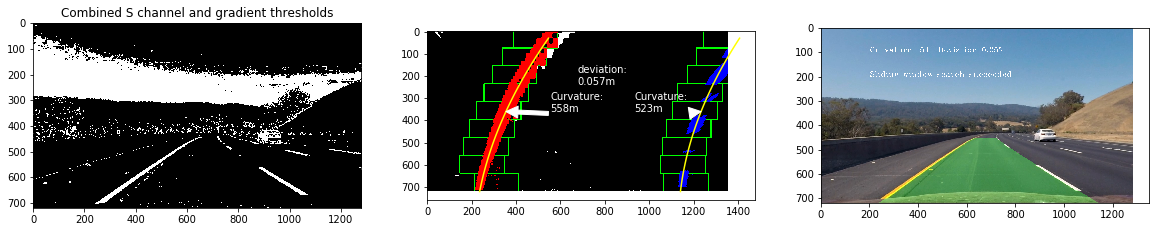

test_images/test2.jpg


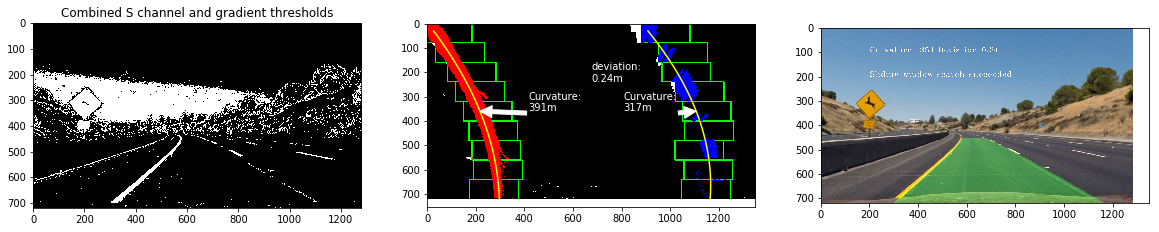

In [415]:
left_masked = None
def pipeline(img, plot=False):
    global left_line, right_line,left_masked

    # camera calibration
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

    # color and gradient thresholding
    combined_binary = color_and_gradient_thresholding(undist)

    # Plotting thresholded images
    if plot:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Combined S channel and gradient thresholds')
        ax1.imshow(combined_binary, cmap='gray')

    # perspective warp the image to have top down view
    binary_warped = cv2.warpPerspective(combined_binary, M, (w+70, rect_h))

    # if we have identified lane lines in previous frames, we can just use
    # points from an area around the previous lines to find new line
    left_mask = left_line.get_mask(binary_warped.shape[0], binary_warped.shape[1])
    right_mask = right_line.get_mask(binary_warped.shape[0], binary_warped.shape[1])
    run_sliding_window_search = False
    if left_mask is not None and right_mask is not None and not plot:
        left_masked = np.zeros_like(binary_warped)
        left_masked[(left_mask == 1) & (binary_warped == 1)] = 1
        right_masked = np.zeros_like(binary_warped)
        right_masked[(right_mask == 1) & (binary_warped == 1)] = 1

        leftx = left_masked.nonzero()[1]
        lefty = left_masked.nonzero()[0]
        rightx = right_masked.nonzero()[1]
        righty = right_masked.nonzero()[0]

        if plot:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            out_img[left_mask.nonzero()[0], left_mask.nonzero()[1]] = [0, 255, 0]
            out_img[right_mask.nonzero()[0], right_mask.nonzero()[1]] = [0, 255, 0]
            out_img[binary_warped.nonzero()[0], binary_warped.nonzero()[1]] = [255, 255, 255]
            out_img[lefty, leftx] = [255, 0, 0]
            out_img[righty, rightx] = [0, 0, 255]

        # Fit a second order polynomial to each
        left_line.fit(leftx, lefty)
        right_line.fit(rightx, righty)

        if sanity_check(left_line, right_line) is False:
            for line in left_line, right_line:
                line.pop() # pop last result
            cv2.putText(undist, "Masked search failed", (200, 150), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
            run_sliding_window_search = True
        else:
            cv2.putText(undist, "Masked search succeeded", (200, 150), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    else:
        run_sliding_window_search = True
    
    if run_sliding_window_search:
        # do a slow sliding window search
        leftx, lefty, rightx, righty, out_img = sliding_window_search(binary_warped, plot)

        # Fit a second order polynomial to each
        left_line.fit(leftx, lefty)
        right_line.fit(rightx, righty)

        if sanity_check(left_line, right_line) is False:
            for line in left_line, right_line:
                line.pop() # pop last result
                line.update(False, None) # indicate we did not find the lanes
            cv2.putText(undist, "Sliding window search failed", (200, 200), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
            # continue with lane lines found in previous frames
        else:
            cv2.putText(undist, "Sliding window search succeeded", (200, 200), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    
#     s = "previous results: {} {}".format(len(left_line.recent_fitted), len(right_line.recent_fitted))
#     cv2.putText(undist, s, (400, 400), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))

    if left_line.best_fit is None or right_line.best_fit is None:
        if plot:
            ax2.imshow(out_img)
            ax3.imshow(out_img)
        return cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)

    # Generate x and y values for plotting
    ploty = np.linspace(30, binary_warped.shape[0])
    left_fitx  = left_line.evaluate(ploty)
    right_fitx = right_line.evaluate(ploty)

    if plot:
        ax2.imshow(out_img)
        ax2.plot(left_fitx,  ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)
    
    # calclulate radius of curvature

    # Define y-value where we want radius of curvature
    # I'll choose the y-value corresponding to the middle of the image
    y_eval = binary_warped.shape[0]/2
    left_curverad  = left_line.get_curvature(y_eval)
    right_curverad = right_line.get_curvature(y_eval)

    if plot:
        lx_eval = left_line.evaluate(y_eval)
        rx_eval = right_line.evaluate(y_eval)
        ax2.annotate('Curvature:\n{}m'.format(int(left_curverad)),  xy=(lx_eval, y_eval), xytext=(lx_eval+200, y_eval), color='w', arrowprops={'color': 'w'})
        ax2.annotate('Curvature:\n{}m'.format(int(right_curverad)), xy=(rx_eval, y_eval), xytext=(rx_eval-300, y_eval), color='w', arrowprops={'color': 'w'})

    # calculate deviation from centre
    y_eval = binary_warped.shape[0] # calculate bottom of image where the head of the car is
    lx_eval = left_line.evaluate(y_eval)
    rx_eval = right_line.evaluate(y_eval)
    deviation = ((lx_eval+rx_eval)/2 - binary_warped.shape[1]/2)*Line.xm_per_pix

    if plot:
        ax2.text(binary_warped.shape[1]/2, binary_warped.shape[0]/3, 'deviation:\n{:.02}m'.format(deviation), color='w')

    # Project lane lines back onto camera view
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(M), (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # put curvature and deviation text on the image
    s = "Curvature {:4d} Deviation {:02.02}"\
            .format(int((left_curverad+right_curverad)/2), deviation)
    cv2.putText(result, s, (200, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))

    if plot:
        ax3.imshow(result)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

test_images = glob.glob('test_images/test*.jpg')

for fname in test_images:
    left_line = Line()
    right_line = Line()
    print(fname)
    img = cv2.imread(fname)
    pipeline(img, plot=True)
    plt.show()


## Running pipeline on video stream

In [404]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [418]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 12%|█▏        | 152/1261 [00:18<02:13,  8.30it/s]


 15%|█▍        | 186/1261 [00:23<02:18,  7.74it/s]

parallel failed 0.0600589627838



 15%|█▍        | 187/1261 [00:23<02:57,  6.05it/s]

parallel failed 0.0614568900507
parallel failed 0.0634784841832
parallel failed 0.0615815120207



 15%|█▌        | 190/1261 [00:23<02:40,  6.67it/s]

parallel failed 0.0641773604067
parallel failed 0.061423655683
parallel failed 0.0662346839025
parallel failed 0.062467778627



 15%|█▌        | 192/1261 [00:24<02:32,  6.99it/s]

parallel failed 0.0682344669301
parallel failed 0.0654167112226
parallel failed 0.0705484713141
parallel failed 0.0669526328597



 15%|█▌        | 194/1261 [00:24<02:38,  6.75it/s]

parallel failed 0.0744462487595
parallel failed 0.0703748654564
parallel failed 0.0748580633899
parallel failed 0.0696458437385



 16%|█▌        | 196/1261 [00:24<02:35,  6.86it/s]

parallel failed 0.0744998244575
parallel failed 0.0690607932644
parallel failed 0.0602464546292



 20%|█▉        | 249/1261 [00:31<02:28,  6.80it/s]

parallel failed 0.0615282459322
parallel failed 0.0601316499262



 20%|██        | 253/1261 [00:32<02:12,  7.61it/s]

parallel failed 0.0607350443606



 32%|███▏      | 404/1261 [00:52<01:51,  7.66it/s]


 44%|████▍     | 555/1261 [01:13<01:38,  7.18it/s]


 45%|████▍     | 563/1261 [01:14<01:52,  6.20it/s]

parallel failed 0.0623398271563
parallel failed 0.062299890872
parallel failed 0.06057655308



 57%|█████▋    | 714/1261 [01:34<01:10,  7.81it/s]


 69%|██████▊   | 865/1261 [01:55<00:59,  6.65it/s]


 81%|████████  | 1016/1261 [02:15<00:32,  7.45it/s]


 81%|████████  | 1022/1261 [02:16<00:35,  6.67it/s]

separation failed
separation failed
separation failed
separation failed



 81%|████████  | 1024/1261 [02:17<00:34,  6.78it/s]

separation failed
separation failed
separation failed
separation failed



 81%|████████▏ | 1026/1261 [02:17<00:34,  6.81it/s]

separation failed
separation failed
separation failed
separation failed



 82%|████████▏ | 1040/1261 [02:19<00:34,  6.40it/s]

curvature failed 349.9569668 182.12280909
curvature failed 352.178002208 184.109534844
curvature failed 339.335306942 168.408970451
curvature failed 329.866311715 171.244587283



 83%|████████▎ | 1041/1261 [02:19<00:34,  6.30it/s]

curvature failed 346.928121458 163.11672014
curvature failed 341.607576341 164.170206957
curvature failed 350.166300874 162.376036196
curvature failed 333.064445989 163.959674689



 83%|████████▎ | 1043/1261 [02:20<00:36,  6.03it/s]

curvature failed 344.052618615 155.684481725
curvature failed 324.942445346 161.207613089
curvature failed 324.326078291 150.447092984
curvature failed 305.773903211 153.742324638



 83%|████████▎ | 1045/1261 [02:20<00:43,  4.97it/s]

curvature failed 325.777912614 137.898632508
curvature failed 306.889021116 148.836581079
curvature failed 357.069528156 140.135914439



 83%|████████▎ | 1047/1261 [02:20<00:37,  5.68it/s]

curvature failed 288.929363284 143.655187654
curvature failed 387.672661673 139.3815218
curvature failed 288.333062486 147.331464894



 95%|█████████▍| 1195/1261 [02:43<00:10,  6.36it/s]


100%|█████████▉| 1260/1261 [02:53<00:00,  6.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 5min 5s, sys: 56.3 s, total: 6min 1s
Wall time: 2min 53s


In [419]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [420]:
white_output = 'test_videos_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4



  1%|          | 8/1200 [00:01<02:46,  7.17it/s]

parallel failed 0.0649105084952
parallel failed 0.0699583737717



  1%|          | 10/1200 [00:01<03:05,  6.41it/s]

parallel failed 0.0608516427463
parallel failed 0.0693837640379



  1%|          | 12/1200 [00:01<03:00,  6.56it/s]

parallel failed 0.0653833802942



  1%|          | 14/1200 [00:02<02:54,  6.81it/s]

parallel failed 0.064682853811



  1%|▏         | 16/1200 [00:02<02:50,  6.95it/s]

parallel failed 0.0625446434578



  2%|▏         | 19/1200 [00:02<02:49,  6.96it/s]

parallel failed 0.0601976104369
parallel failed 0.062208030918



  2%|▏         | 22/1200 [00:03<02:49,  6.97it/s]

parallel failed 0.0644999302239
parallel failed 0.0612954028348



  2%|▏         | 25/1200 [00:03<02:50,  6.90it/s]

parallel failed 0.0644385105333
parallel failed 0.0627937359586



  2%|▏         | 27/1200 [00:03<03:04,  6.35it/s]

parallel failed 0.0680464720793
parallel failed 0.0648291778866
parallel failed 0.0677057110491



  2%|▏         | 28/1200 [00:04<03:12,  6.10it/s]

parallel failed 0.0635267099897
parallel failed 0.0664381742058
parallel failed 0.061677209868



  2%|▎         | 30/1200 [00:04<03:27,  5.64it/s]

parallel failed 0.0657127619037
parallel failed 0.0602840164207
parallel failed 0.0757414516859



  3%|▎         | 31/1200 [00:04<03:31,  5.53it/s]

parallel failed 0.0615881003453
parallel failed 0.0877166744593
parallel failed 0.071430261842



  3%|▎         | 33/1200 [00:05<03:41,  5.26it/s]

parallel failed 0.0916375127448
parallel failed 0.0746598509791
parallel failed 0.0986069682265



  3%|▎         | 35/1200 [00:05<03:38,  5.33it/s]

parallel failed 0.0695351562765
parallel failed 0.112448477423
parallel failed 0.0680298341711



  3%|▎         | 37/1200 [00:05<02:58,  6.51it/s]

separation failed



  6%|▋         | 76/1200 [00:11<02:51,  6.55it/s]

parallel failed 0.0605698950622



  7%|▋         | 79/1200 [00:11<02:49,  6.62it/s]

parallel failed 0.0637546035073



  8%|▊         | 100/1200 [00:14<02:36,  7.03it/s]

parallel failed 0.0710695650252



  8%|▊         | 102/1200 [00:14<02:39,  6.90it/s]

parallel failed 0.0843187351991



  9%|▊         | 104/1200 [00:15<02:45,  6.63it/s]

parallel failed 0.0634208141499
parallel failed 0.0604212322614
separation failed



  9%|▉         | 106/1200 [00:15<02:47,  6.53it/s]

parallel failed 0.0611382860433
parallel failed 0.0623240673292
parallel failed 0.0619387362938
parallel failed 0.065830337064



  9%|▉         | 107/1200 [00:15<02:48,  6.50it/s]

separation failed
separation failed
separation failed
separation failed



  9%|▉         | 109/1200 [00:16<02:55,  6.22it/s]

separation failed
separation failed
separation failed
separation failed



  9%|▉         | 111/1200 [00:16<03:02,  5.98it/s]

separation failed
parallel failed 0.239509943366
curvature failed 73.6046775985 268.422666063



  9%|▉         | 113/1200 [00:16<02:50,  6.37it/s]

separation failed



 10%|█         | 120/1200 [00:17<02:45,  6.53it/s]

curvature failed 176.396466874 707.391583238
curvature failed 149.627615087 510.434304968
curvature failed 176.803436901 342.854239904



 10%|█         | 121/1200 [00:17<02:49,  6.36it/s]

curvature failed 131.134200753 408.551494687
curvature failed 155.617348967 357.829191708
curvature failed 107.595609355 328.863152929
curvature failed 122.756182174 347.807012707



 10%|█         | 123/1200 [00:18<02:49,  6.34it/s]

curvature failed 90.2097917129 324.235343471
curvature failed 94.9498633794 435.172713407
curvature failed 79.195818803 481.126441783
curvature failed 92.8055280668 789.144824428



 10%|█         | 126/1200 [00:18<02:44,  6.53it/s]

curvature failed 85.0161146721 524.870397527
curvature failed 87.3290181953 8128.51940006
curvature failed 143.452333706 165.681715813
curvature failed 134.653305403 364.510719533



 11%|█         | 130/1200 [00:19<02:37,  6.80it/s]

curvature failed 516.306963872 191.464443314



 11%|█         | 132/1200 [00:19<02:42,  6.57it/s]

parallel failed 0.0600814741675



 11%|█         | 133/1200 [00:19<02:44,  6.47it/s]

parallel failed 0.0690670453959
parallel failed 0.0659322878419
parallel failed 0.075543059746
parallel failed 0.0727214269816



 11%|█▏        | 136/1200 [00:20<02:43,  6.51it/s]

parallel failed 0.0792782334748
parallel failed 0.0718802526838
parallel failed 0.0856509871385
parallel failed 0.089010306791



 12%|█▏        | 138/1200 [00:20<02:39,  6.66it/s]

parallel failed 0.0875383622741
parallel failed 0.0949500892711
parallel failed 0.105257051864
parallel failed 0.16148237777



 12%|█▏        | 139/1200 [00:20<02:23,  7.40it/s]

curvature failed 478.416191585 191.949705069
curvature failed 363.105542765 163.163227852
curvature failed 154.238935368 606.172714176



 12%|█▏        | 144/1200 [00:21<01:57,  8.98it/s]

curvature failed 172.301456643 627.85816426
parallel failed 0.242674608077
parallel failed 0.0860544891956



 12%|█▏        | 146/1200 [00:21<01:51,  9.49it/s]

curvature failed 154.181408772 245.993469564
curvature failed 136.095794431 2165.85338116
curvature failed 130.434952203 2073.02866639



 12%|█▎        | 150/1200 [00:21<01:44, 10.01it/s]

curvature failed 129.68074166 154.144331479
curvature failed 157.265404962 32.2510150138
parallel failed 0.101432186029



 13%|█▎        | 152/1200 [00:21<01:42, 10.20it/s]

curvature failed 166.255508105 183.562366285
curvature failed 205.241695356 195.317563495
curvature failed 108.049572794 29.8287905261



 13%|█▎        | 156/1200 [00:22<01:34, 11.08it/s]

curvature failed 88.0681047504 42.0849389293
curvature failed 72.7657890748 52.8909007219
curvature failed 61.2787373917 45.3126270464



 13%|█▎        | 158/1200 [00:22<01:50,  9.40it/s]

curvature failed 52.1217649264 36.9322256273
curvature failed 38.4190475166 48.2629605087



 13%|█▎        | 160/1200 [00:22<01:41, 10.21it/s]

curvature failed 71.0646847738 118.842631947
curvature failed 30.1005784181 38.5475093996
curvature failed 67.8929259356 27.8110901636



 14%|█▎        | 164/1200 [00:22<01:34, 10.94it/s]

curvature failed 73.849025197 28.1109828168
curvature failed 46.468531281 28.2068494056
curvature failed 36.0950169225 34.9350521109



 14%|█▍        | 166/1200 [00:23<01:29, 11.49it/s]

curvature failed 42.9569890822 42.5143084739
curvature failed 27.8076680504 28.5522354476
curvature failed 39.1425986457 36.6035723008



 14%|█▍        | 170/1200 [00:23<01:23, 12.36it/s]

curvature failed 34.2489865798 36.1775612552
curvature failed 39.7590858795 36.6058616259
curvature failed 39.216283361 28.4642625636



 14%|█▍        | 172/1200 [00:23<01:21, 12.61it/s]

curvature failed 43.4850439941 29.3720250336
curvature failed 49.3365359767 53.2291113485
curvature failed 27.3765682759 34.4815333802



 15%|█▍        | 176/1200 [00:23<01:20, 12.78it/s]

curvature failed 28.0692134288 87.408570648
curvature failed 33.415794913 147.745721624
curvature failed 31.5259399243 108.949232609



 15%|█▍        | 178/1200 [00:23<01:20, 12.77it/s]

curvature failed 29.5221578117 165.448102402
curvature failed 29.8246992446 82.0477812268
curvature failed 31.3999657806 94.1398858375



 15%|█▌        | 182/1200 [00:24<01:20, 12.66it/s]

curvature failed 34.1626455263 112.210092857
curvature failed 42.0910107595 3090.83720181
curvature failed 47.2184006884 220.921791067



 15%|█▌        | 184/1200 [00:24<01:21, 12.54it/s]

curvature failed 80.9836441695 239.90389839
parallel failed 0.15424296544
curvature failed 167.393703746 23614.8116213



 16%|█▌        | 186/1200 [00:24<01:24, 11.97it/s]

parallel failed 0.124842400656



 16%|█▌        | 189/1200 [00:25<02:02,  8.23it/s]

parallel failed 0.0665421142804
separation failed
parallel failed 0.104006707769
separation failed



 16%|█▌        | 191/1200 [00:25<01:50,  9.10it/s]

parallel failed 0.194417363644
parallel failed 0.178772263047
separation failed



 16%|█▋        | 195/1200 [00:25<01:42,  9.83it/s]

parallel failed 0.0613586843559
separation failed
parallel failed 0.131953938734



 16%|█▋        | 197/1200 [00:25<01:41,  9.85it/s]

separation failed
parallel failed 0.162991227625
parallel failed 0.179057948995



 17%|█▋        | 199/1200 [00:26<01:39, 10.06it/s]

parallel failed 0.0610053555134
separation failed
parallel failed


 17%|█▋        | 209/1200 [00:27<02:21,  7.02it/s]

 0.315333506278
parallel failed 0.065306820666



 18%|█▊        | 212/1200 [00:28<02:57,  5.58it/s]

parallel failed 0.0673002386579



 18%|█▊        | 213/1200 [00:28<03:04,  5.34it/s]

parallel failed 0.0692849574403
parallel failed 0.0651075185218
parallel failed 0.0742308859069



 18%|█▊        | 214/1200 [00:28<03:30,  4.68it/s]

parallel failed 0.0676865247918
parallel failed 0.0741549574909



 18%|█▊        | 215/1200 [00:28<03:27,  4.75it/s]

parallel failed 0.0654149609036
parallel failed 0.0654133677461



 18%|█▊        | 221/1200 [00:29<02:52,  5.69it/s]

parallel failed 0.0616632712807



 19%|█▉        | 231/1200 [00:31<02:48,  5.75it/s]

parallel failed 0.0636815913281



 20%|█▉        | 234/1200 [00:31<02:46,  5.81it/s]

parallel failed 0.0619178623897



 20%|█▉        | 237/1200 [00:32<02:44,  5.85it/s]

parallel failed 0.0624562675662



 20%|██        | 241/1200 [00:33<02:40,  5.97it/s]

parallel failed 0.0624541306433
separation failed
parallel failed 0.0626992609078



 20%|██        | 242/1200 [00:33<02:49,  5.67it/s]

separation failed
parallel failed 0.0608985255821



 20%|██        | 243/1200 [00:33<02:56,  5.41it/s]

separation failed
curvature failed 185.436902618 1152.88556248
parallel failed


 20%|██        | 245/1200 [00:33<03:05,  5.15it/s]

 0.0700312497376
parallel failed 0.0724922334485
parallel failed 0.0636675474692
parallel failed 0.0695176646482



 21%|██        | 247/1200 [00:34<03:00,  5.27it/s]

parallel failed 0.0602740593333
curvature failed 147.389872911 1211.95329507
parallel failed 0.0930937506798



 21%|██        | 248/1200 [00:34<03:02,  5.21it/s]

curvature failed 159.276186061 1051.851818
parallel failed 0.0995114285363
curvature failed


 21%|██        | 250/1200 [00:34<02:41,  5.90it/s]

 169.831350339 678.813774381
parallel failed 0.0818610589075
parallel failed 0.132673403059



 21%|██        | 252/1200 [00:34<02:18,  6.84it/s]

parallel failed 0.122278936451
parallel failed 0.105402977467



 21%|██        | 254/1200 [00:35<02:13,  7.09it/s]

parallel failed 0.11043951497
parallel failed 0.102860719254



 21%|██▏       | 256/1200 [00:35<02:01,  7.75it/s]

parallel failed 0.112270129578
parallel failed 0.144711009751



 22%|██▏       | 258/1200 [00:35<01:58,  7.98it/s]

parallel failed 0.158084201332



 23%|██▎       | 281/1200 [00:39<02:18,  6.64it/s]

curvature failed 1134.26822441 191.844763183
curvature failed 886.723935627 174.541010525



 24%|██▎       | 284/1200 [00:39<02:17,  6.64it/s]

curvature failed 724.33119246 164.559560459
curvature failed 661.680449008 191.733916961
curvature failed 590.97797317 153.723343249
parallel failed 0.0615487935667



 24%|██▍       | 286/1200 [00:39<02:17,  6.63it/s]

curvature failed 714.421156084 149.698808607
parallel failed 0.0662583791139
curvature failed 1488.95651995 162.839593064
parallel failed 0.0712076699096



 24%|██▍       | 288/1200 [00:40<02:14,  6.78it/s]

curvature failed 1008.90381213 152.041953636
parallel failed 0.0770507774411



 25%|██▍       | 296/1200 [00:41<02:05,  7.22it/s]

parallel failed 0.0706188223847



 25%|██▍       | 298/1200 [00:41<02:09,  6.96it/s]

curvature failed 937.239907487 164.327355352
parallel failed 0.0694061573034
curvature failed 1589.9083015 137.774838073
curvature failed 610.614653891 184.622307778



 25%|██▌       | 300/1200 [00:41<02:10,  6.90it/s]

curvature failed 1991.60227177 127.130230743
curvature failed 913.105326313 172.263035172
curvature failed 2833.68611647 118.233668354
curvature failed 743.25371149 168.368144816



 25%|██▌       | 301/1200 [00:41<02:10,  6.88it/s]

curvature failed 867.792359128 137.027978094
curvature failed 615.834003921 158.612911793



 25%|██▌       | 303/1200 [00:42<02:31,  5.91it/s]

curvature failed 506.324213121 102.961720451
curvature failed 414.335679663 170.44209574
curvature failed 1335.64099261 97.563598095
parallel failed 0.0687750876504



 25%|██▌       | 305/1200 [00:42<02:16,  6.54it/s]

curvature failed 320.821184835 95.4946127887



 26%|██▌       | 307/1200 [00:42<02:11,  6.78it/s]

curvature failed 193.596718525 217.262286265
curvature failed 173.214526345 315.282790241
curvature failed 172.768860242 360.384187853



 26%|██▌       | 309/1200 [00:43<02:10,  6.84it/s]

curvature failed 168.878535589 282.636740885
curvature failed 179.966050702 312.975513052
curvature failed 135.332493571 1009.28971087
curvature failed 151.976092082 647.424856484



 26%|██▌       | 311/1200 [00:43<02:05,  7.08it/s]

curvature failed 131.0480426 1419.43613038
curvature failed 158.792106027 698.595506799
curvature failed 195.621206579 472.200965413
parallel failed 0.0750358983514



 26%|██▋       | 317/1200 [00:44<01:57,  7.50it/s]

parallel failed 0.0664231933877



 27%|██▋       | 319/1200 [00:44<02:04,  7.09it/s]

parallel failed 0.0988049960087
parallel failed 0.0944698455015
curvature failed 561.82289057 184.974104091
parallel failed 0.0995925423037



 27%|██▋       | 321/1200 [00:44<02:07,  6.91it/s]

curvature failed 420.060619218 160.68989696
curvature failed 437.772499742 192.668427909
curvature failed 1963.47993697 159.472515197



 27%|██▋       | 323/1200 [00:45<02:01,  7.21it/s]

curvature failed 989.725228225 179.72125108



 27%|██▋       | 325/1200 [00:45<02:01,  7.22it/s]

curvature failed 496.5330339 178.392752979
curvature failed 405.04153424 187.586351068



 27%|██▋       | 329/1200 [00:45<01:53,  7.67it/s]

curvature failed 221.918370133 189.259919538



 28%|██▊       | 331/1200 [00:46<01:57,  7.39it/s]

curvature failed 173.734188726 182.034334185
curvature failed 167.203046244 203.801872556
parallel failed 0.0942018790596



 28%|██▊       | 333/1200 [00:46<02:03,  7.02it/s]

curvature failed 160.188851231 196.394376685
parallel failed 0.115199041843
curvature failed 171.943599196 197.530980689
parallel failed 0.16111777697



 28%|██▊       | 335/1200 [00:46<02:07,  6.77it/s]

parallel failed 0.104915054523
curvature failed 128.324576968 268.157432303
curvature failed 166.809986503 174.872585027
parallel failed 0.178497300899



 28%|██▊       | 337/1200 [00:47<02:10,  6.61it/s]

parallel failed 0.153715191154
parallel failed 0.184710883439
parallel failed 0.17174062909
parallel failed 0.152785388464



 28%|██▊       | 338/1200 [00:47<02:08,  6.70it/s]

curvature failed 177.023294662 169.301607843
parallel failed 0.16795207915



 28%|██▊       | 340/1200 [00:47<02:15,  6.36it/s]

curvature failed 141.176936331 371.177896461
curvature failed 95.0583631578 291.151578625
curvature failed 35.6163247529 150.70504982



 29%|██▊       | 343/1200 [00:47<01:48,  7.89it/s]

curvature failed 41.1293284615 136.219274699
curvature failed 30.7442053028 97.7573563461
curvature failed 32.2937825733 112.436852387



 29%|██▉       | 345/1200 [00:48<02:02,  7.00it/s]

curvature failed 30.5655918011 308.701846651
curvature failed 34.2315908074 66.8704693391



 29%|██▉       | 347/1200 [00:48<01:48,  7.85it/s]

curvature failed 426.639012601 63.2905651308
parallel failed 0.204778018634
curvature failed 85.7851063994 600.496431112



 29%|██▉       | 350/1200 [00:48<01:36,  8.78it/s]

parallel failed 0.0788638981649
parallel failed 0.23745708235



 29%|██▉       | 352/1200 [00:48<01:35,  8.88it/s]

parallel failed 0.242790054618
curvature failed 136.581599457 1273.03222871



 30%|██▉       | 355/1200 [00:49<01:30,  9.30it/s]

curvature failed 46.8509316146 136.606409888
curvature failed 59.1765196424 551.908432649
curvature failed 53.267616484 1133.11180572



 30%|██▉       | 357/1200 [00:49<01:29,  9.42it/s]

curvature failed 53.6898642968 3970.17302614
curvature failed 93.4352069989 2450.55055367
parallel failed


 30%|███       | 360/1200 [00:49<01:28,  9.47it/s]

 0.0906563230635
curvature failed 62.292987278 759.247017894
curvature failed 47.1164006129 887.657899116



 30%|███       | 362/1200 [00:49<01:28,  9.49it/s]

separation failed
parallel failed 0.193149962803



 30%|███       | 364/1200 [00:50<01:32,  9.06it/s]

parallel failed 0.198568543897
parallel failed 0.0821249529819



 30%|███       | 366/1200 [00:50<01:41,  8.20it/s]

parallel failed 0.0848435974894
parallel failed 0.149514204226



 31%|███       | 368/1200 [00:50<01:50,  7.55it/s]

parallel failed 0.0750854120125
parallel failed 0.124622564831



 31%|███       | 370/1200 [00:51<01:56,  7.10it/s]

parallel failed 0.176703847478
separation failed



 31%|███       | 372/1200 [00:51<01:57,  7.02it/s]

separation failed
separation failed



 31%|███       | 374/1200 [00:51<01:56,  7.11it/s]

separation failed
separation failed



 35%|███▌      | 424/1200 [01:00<02:27,  5.27it/s]

separation failed
separation failed



 36%|███▌      | 426/1200 [01:01<03:03,  4.21it/s]

separation failed
separation failed



 36%|███▌      | 427/1200 [01:01<02:59,  4.30it/s]

separation failed
separation failed



 36%|███▌      | 428/1200 [01:01<02:58,  4.32it/s]

separation failed



 37%|███▋      | 447/1200 [01:05<02:11,  5.71it/s]

separation failed
separation failed
separation failed



 37%|███▋      | 449/1200 [01:05<02:13,  5.61it/s]

separation failed
separation failed



 40%|████      | 485/1200 [01:10<02:13,  5.37it/s]

parallel failed 0.0612613152127
parallel failed 0.0652461579657



 41%|████      | 489/1200 [01:11<01:59,  5.97it/s]

parallel failed 0.0895889448751
parallel failed 0.09531318533



 41%|████      | 492/1200 [01:12<01:58,  5.95it/s]

parallel failed 0.100016910671
parallel failed 0.0645968805523
parallel failed 0.115582901525
curvature failed 188.330543026 229.883555152



 41%|████      | 493/1200 [01:12<02:00,  5.85it/s]

curvature failed 159.472262097 196.732266571
curvature failed 153.112455722 226.534250779
curvature failed 125.102915521 186.512713856
curvature failed 118.306806008 224.226753243



 41%|████▏     | 495/1200 [01:12<01:57,  6.01it/s]

curvature failed 101.585961886 169.771409007
curvature failed 91.0092823155 216.017222082
curvature failed 87.7108931178 227.953835885
curvature failed 80.5741901775 221.81689619



 42%|████▏     | 498/1200 [01:13<01:51,  6.29it/s]

curvature failed 86.0179089973 296.514769453
parallel failed 0.104466972441
parallel failed 0.0903549390898
parallel failed 0.0622274578546



 42%|████▏     | 500/1200 [01:13<01:38,  7.13it/s]

parallel failed 0.117893435127
parallel failed 0.0685320459336
separation failed



 42%|████▏     | 502/1200 [01:13<01:27,  7.96it/s]

parallel failed 0.128932655669
parallel failed 0.0738319748611
separation failed



 42%|████▏     | 505/1200 [01:13<01:18,  8.86it/s]

parallel failed 0.0689665253762
parallel failed 0.0854405099929
separation failed



 42%|████▏     | 509/1200 [01:14<01:10,  9.83it/s]

parallel failed 0.0716236366002
separation failed
separation failed



 43%|████▎     | 511/1200 [01:14<01:09,  9.98it/s]

separation failed
separation failed
separation failed



 43%|████▎     | 515/1200 [01:14<01:06, 10.24it/s]

separation failed
separation failed
separation failed



 43%|████▎     | 517/1200 [01:15<01:17,  8.83it/s]

curvature failed 6475.82698326 171.676702558
curvature failed 9073.91471532 162.497427903



 43%|████▎     | 519/1200 [01:15<01:10,  9.61it/s]

curvature failed 2276.83256307 140.783221761
curvature failed 1167.74726831 138.459542138
curvature failed 1323.96840292 130.463772136



 44%|████▎     | 523/1200 [01:15<01:04, 10.51it/s]

curvature failed 1231.22433214 168.912295686
curvature failed 2385.64247322 147.333983956
curvature failed 568.513850775 130.487929874



 44%|████▍     | 525/1200 [01:15<01:02, 10.85it/s]

curvature failed 399.307494854 165.003254936
curvature failed 221.027527494 89.8355423685
curvature failed 150.117944816 87.5339765557



 44%|████▍     | 529/1200 [01:16<00:57, 11.61it/s]

curvature failed 121.983458011 73.1803894064
curvature failed 99.4226685741 75.3114887211
curvature failed 104.826664334 65.2173788681



 44%|████▍     | 531/1200 [01:16<01:11,  9.39it/s]

curvature failed 293.179692376 67.1692376911
curvature failed 313.456395423 63.5903807237



 44%|████▍     | 533/1200 [01:16<01:05, 10.14it/s]

parallel failed 0.13233425762
curvature failed 248.904382049 71.4057410185
curvature failed 205.770270947 84.6777407242



 45%|████▍     | 537/1200 [01:16<01:01, 10.84it/s]

curvature failed 185.702890015 87.7561939483
curvature failed 162.441313187 104.147521644
curvature failed 160.409807009 5314.01122677



 45%|████▍     | 539/1200 [01:17<00:58, 11.24it/s]

curvature failed 1153.5504551 120.13220821
parallel failed 0.377998706444
parallel failed 0.100892347117



 45%|████▌     | 543/1200 [01:17<00:56, 11.55it/s]

parallel failed 0.159065870683
curvature failed 281.226201635 156.734369974
curvature failed 270.830060446 76.2084181057



 45%|████▌     | 545/1200 [01:17<00:56, 11.51it/s]

curvature failed 249.313819651 74.8379637446
curvature failed 256.871088228 77.3062580255
curvature failed 201.072020867 123.758240515



 46%|████▌     | 547/1200 [01:17<00:59, 11.04it/s]

curvature failed 224.390777705 119.435997276
curvature failed 178.610308551 350.700113532



 46%|████▌     | 549/1200 [01:17<01:02, 10.40it/s]

curvature failed 192.17590667 450.233632815
curvature failed 147.83938476 91.0569345879



 46%|████▌     | 553/1200 [01:18<01:03, 10.26it/s]

curvature failed 149.17178461 471.014297247
curvature failed 142.090505847 451.638262823
curvature failed 158.230535875 209.278326971



 46%|████▋     | 555/1200 [01:18<01:02, 10.39it/s]

curvature failed 146.720818714 181.93977534
curvature failed 125.023837087 438.940955184
curvature failed 127.179809784 276.113188432



 47%|████▋     | 559/1200 [01:18<00:58, 10.95it/s]

curvature failed 141.22219807 331.260322005
curvature failed 120.425538424 416.249589562
curvature failed 119.873583084 331.231808643



 47%|████▋     | 561/1200 [01:19<00:57, 11.21it/s]

curvature failed 138.703604314 555.350081966
curvature failed 122.499440189 13596.8609848
curvature failed 129.186614027 2422.23529935



 47%|████▋     | 565/1200 [01:19<00:58, 10.85it/s]

curvature failed 128.745781195 15010.104243
curvature failed 107.18524003 661.562913916
curvature failed 107.206181199 568.159312428



 47%|████▋     | 567/1200 [01:19<00:57, 10.98it/s]

curvature failed 98.6944895177 1025.79000468
curvature failed 97.9570806795 552.672239011
curvature failed 84.8611602263 574.409542626



 48%|████▊     | 571/1200 [01:20<00:56, 11.06it/s]

curvature failed 104.431147317 550.468641499
curvature failed 124.136827947 699.541889508
curvature failed 102.519993061 505.312442024



 48%|████▊     | 573/1200 [01:20<00:57, 10.85it/s]

curvature failed 99.9133112338 511.330084856
curvature failed 101.419553143 483.580795098
curvature failed 111.340810699 515.66052774



 48%|████▊     | 577/1200 [01:20<00:59, 10.48it/s]

curvature failed 116.821663894 415.479455703
curvature failed 107.578195088 374.613185887
curvature failed 114.358776095 480.63781452



 48%|████▊     | 579/1200 [01:20<01:03,  9.78it/s]

curvature failed 117.092689418 571.62775614
curvature failed 115.966228062 494.458835285



 48%|████▊     | 581/1200 [01:21<01:06,  9.37it/s]

curvature failed 110.445698924 587.552206741
curvature failed 113.243287043 818.10674819



 49%|████▊     | 583/1200 [01:21<01:07,  9.16it/s]

curvature failed 118.336878589 1226.38165703
curvature failed 111.520500596 4116.17847728



 49%|████▉     | 585/1200 [01:21<01:08,  8.92it/s]

curvature failed 144.134818211 2461.6657071
curvature failed 175.828437669 1676.06220165



 49%|████▉     | 586/1200 [01:21<01:11,  8.62it/s]

curvature failed 104.15436747 855.82843889



 49%|████▉     | 588/1200 [01:21<01:25,  7.18it/s]

parallel failed 0.334481274337
curvature failed 57.6060753294 519.42345676



 49%|████▉     | 590/1200 [01:22<01:19,  7.65it/s]

parallel failed 0.134620311839
curvature failed 95.3668934961 278.586555913



 49%|████▉     | 592/1200 [01:22<01:13,  8.31it/s]

curvature failed 85.0661898269 232.949207251
curvature failed 361.333355201 186.007851228
parallel failed 0.158216148094



 50%|████▉     | 595/1200 [01:22<01:08,  8.77it/s]

parallel failed 0.141835253011
separation failed



 50%|████▉     | 597/1200 [01:22<01:07,  8.90it/s]

parallel failed 0.0702345721749
parallel failed 0.0611884258835



 50%|████▉     | 599/1200 [01:23<01:26,  6.98it/s]

parallel failed 0.0687260394272
curvature failed 88.2799498471 1084.61981395



 50%|█████     | 600/1200 [01:23<01:20,  7.41it/s]

parallel failed 0.0794366227705
parallel failed 0.0989070382582



 51%|█████     | 614/1200 [01:25<01:39,  5.87it/s]

parallel failed 0.0611639336795
parallel failed 0.0617706010231



 51%|█████▏    | 615/1200 [01:25<01:53,  5.14it/s]

parallel failed 0.0673993141234
parallel failed 0.0681381843322



 51%|█████▏    | 616/1200 [01:26<02:10,  4.49it/s]

parallel failed 0.0713277091446
parallel failed 0.0690560489621



 51%|█████▏    | 617/1200 [01:26<02:08,  4.55it/s]

parallel failed 0.0745220535669
parallel failed 0.0794136688307



 52%|█████▏    | 618/1200 [01:26<02:04,  4.67it/s]

parallel failed 0.0773826975275
parallel failed 0.0738976224278



 52%|█████▏    | 619/1200 [01:26<02:06,  4.60it/s]

parallel failed 0.0789555389707
parallel failed 0.0713118493792



 52%|█████▏    | 620/1200 [01:26<02:10,  4.44it/s]

parallel failed 0.0826235637925
parallel failed 0.0701946363447



 52%|█████▏    | 621/1200 [01:27<02:15,  4.29it/s]

parallel failed 0.0864937105883
parallel failed 0.0926021243761



 52%|█████▏    | 623/1200 [01:27<01:54,  5.02it/s]

parallel failed 0.0975272945866
parallel failed 0.106751299781
parallel failed 0.111087584461



 52%|█████▏    | 625/1200 [01:27<01:38,  5.82it/s]

parallel failed 0.106320069802
parallel failed 0.121200329614



 52%|█████▏    | 627/1200 [01:28<01:27,  6.55it/s]

parallel failed 0.11683867629
parallel failed 0.103623160107



 52%|█████▏    | 629/1200 [01:28<01:25,  6.68it/s]

parallel failed 0.103967386512
parallel failed 0.104625600009



 53%|█████▎    | 631/1200 [01:28<01:29,  6.34it/s]

parallel failed 0.107068894427
parallel failed 0.0962359397778



 53%|█████▎    | 633/1200 [01:29<01:26,  6.55it/s]

parallel failed 0.089960252894
parallel failed 0.0877302906033



 53%|█████▎    | 635/1200 [01:29<01:25,  6.57it/s]

parallel failed 0.0838144757231
parallel failed 0.0750505617871



 53%|█████▎    | 637/1200 [01:29<01:26,  6.50it/s]

parallel failed 0.0738665900426
parallel failed 0.0755733328828



 53%|█████▎    | 641/1200 [01:30<01:44,  5.36it/s]

parallel failed 0.0636390104854



 54%|█████▎    | 644/1200 [01:31<02:05,  4.42it/s]

parallel failed 0.0601863077423



 54%|█████▍    | 647/1200 [01:31<01:54,  4.83it/s]

parallel failed 0.0639729047936



 54%|█████▍    | 649/1200 [01:32<01:52,  4.91it/s]

parallel failed 0.0648283358795
parallel failed 0.0620524670566



 54%|█████▍    | 650/1200 [01:32<01:53,  4.87it/s]

parallel failed 0.0655406460048



 54%|█████▍    | 652/1200 [01:32<01:47,  5.10it/s]

parallel failed 0.0739322311683
parallel failed 0.0650466702801



 54%|█████▍    | 653/1200 [01:32<02:11,  4.16it/s]

parallel failed 0.0739945671463
parallel failed 0.0620976779217



 55%|█████▍    | 654/1200 [01:33<02:14,  4.05it/s]

parallel failed 0.079174267345
parallel failed 0.0619546726935



 55%|█████▍    | 655/1200 [01:33<02:12,  4.12it/s]

parallel failed 0.0836417697173
parallel failed 0.0654698380173



 55%|█████▍    | 656/1200 [01:33<02:10,  4.16it/s]

parallel failed 0.0938161422497
parallel failed 0.0715589801389



 55%|█████▍    | 657/1200 [01:33<02:05,  4.31it/s]

parallel failed 0.0882207722856
parallel failed 0.0624895235124



 55%|█████▍    | 658/1200 [01:34<02:01,  4.45it/s]

parallel failed 0.129721586029
parallel failed 0.0813971347069



 55%|█████▍    | 659/1200 [01:34<02:01,  4.46it/s]

parallel failed 0.150401875524
parallel failed 0.0876435633862



 55%|█████▌    | 660/1200 [01:34<02:03,  4.39it/s]

parallel failed 0.294750979449
parallel failed 0.185496070406



 55%|█████▌    | 662/1200 [01:34<01:47,  5.02it/s]

parallel failed 0.0869888802609
parallel failed 0.108023261466



 55%|█████▌    | 664/1200 [01:35<01:32,  5.79it/s]

parallel failed 0.121201604743
parallel failed 0.113168630174



 56%|█████▌    | 666/1200 [01:35<01:23,  6.39it/s]

curvature failed 138.608896821 35912.175514
curvature failed 158.121180222 3705.67105487



 56%|█████▌    | 668/1200 [01:35<01:18,  6.75it/s]

curvature failed 154.639607798 1218.07752425
curvature failed 152.444388093 1570.7919877



 56%|█████▌    | 669/1200 [01:35<01:17,  6.84it/s]

curvature failed 160.920621303 598.952522102



 56%|█████▌    | 671/1200 [01:36<01:26,  6.11it/s]

curvature failed 183.256650076 537.552213847
curvature failed 170.906000994 323.868476546



 56%|█████▌    | 673/1200 [01:36<01:22,  6.42it/s]

separation failed
separation failed



 56%|█████▋    | 675/1200 [01:36<01:13,  7.11it/s]

separation failed
parallel failed 6.68039492638



 56%|█████▋    | 677/1200 [01:37<01:08,  7.62it/s]

parallel failed 0.822699971281
curvature failed 616.582098955 126.256017178



 57%|█████▋    | 679/1200 [01:37<01:07,  7.69it/s]

curvature failed 229.576188859 117.437668867
curvature failed 4591.20634532 106.670904212



 57%|█████▋    | 681/1200 [01:37<01:04,  8.02it/s]

curvature failed 470.980070523 113.397858915
parallel failed 0.319277608856



 57%|█████▋    | 683/1200 [01:37<01:01,  8.45it/s]

curvature failed 197.651428149 122.869299672
curvature failed 187.911225312 113.981302296



 57%|█████▋    | 685/1200 [01:38<01:01,  8.37it/s]

curvature failed 612.357715301 109.406802483
parallel failed 0.0947898687325



 57%|█████▋    | 687/1200 [01:38<01:00,  8.42it/s]

separation failed
parallel failed 0.133349069161



 57%|█████▋    | 689/1200 [01:38<00:59,  8.65it/s]

parallel failed 0.0838578585402
separation failed



 58%|█████▊    | 691/1200 [01:38<00:57,  8.80it/s]

parallel failed 0.253649757638
parallel failed 0.0803621741051



 58%|█████▊    | 693/1200 [01:38<00:56,  8.93it/s]

parallel failed 1.20431274326
parallel failed 0.147377526735



 58%|█████▊    | 695/1200 [01:39<00:55,  9.06it/s]

parallel failed 0.12954384879
parallel failed 1.30915064337



 58%|█████▊    | 697/1200 [01:39<00:53,  9.33it/s]

parallel failed 0.995443063108
parallel failed 1.09218551551



 58%|█████▊    | 699/1200 [01:39<00:52,  9.48it/s]

separation failed
curvature failed 156.011699677 482.395316925



 58%|█████▊    | 701/1200 [01:39<00:52,  9.51it/s]

parallel failed 0.637379300317
parallel failed 0.271685407278



 59%|█████▊    | 703/1200 [01:40<00:53,  9.35it/s]

parallel failed 0.341299689691
curvature failed 995.437653112 187.85465466



 59%|█████▉    | 706/1200 [01:40<00:50,  9.69it/s]

parallel failed 1.33975081586
curvature failed 395.900118481 136.274375223
separation failed



 59%|█████▉    | 708/1200 [01:40<00:48, 10.06it/s]

parallel failed 1.27108593097
parallel failed 1.95000656269
curvature failed 186.065438521 238.693195828



 59%|█████▉    | 712/1200 [01:40<00:44, 10.98it/s]

curvature failed 158.703478346 215.9515172
curvature failed 612.714103302 70.6812856698
separation failed



 60%|█████▉    | 714/1200 [01:41<00:44, 10.84it/s]

separation failed
parallel failed 0.53619368622
curvature failed 329.567667059 28.3991409198



 60%|█████▉    | 718/1200 [01:41<00:43, 11.19it/s]

curvature failed 875.715251977 33.2091452281
curvature failed 362.051400757 47.5001949681
curvature failed 275.962801411 37.2925703342



 60%|██████    | 720/1200 [01:41<00:44, 10.85it/s]

curvature failed 669.496758988 48.0802235559
curvature failed 726.42761485 75.9374065523
curvature failed 670.908001335 112.683335822



 60%|██████    | 722/1200 [01:41<00:46, 10.28it/s]

curvature failed 633.361890065 169.088414111
parallel failed 0.207531944258



 60%|██████    | 725/1200 [01:42<00:49,  9.67it/s]

curvature failed 622.933646889 139.032466526
parallel failed 0.173929154117



 61%|██████    | 727/1200 [01:42<00:51,  9.25it/s]

parallel failed 0.146464195914
parallel failed 0.0694129283635



 61%|██████    | 730/1200 [01:42<01:14,  6.31it/s]

parallel failed 0.0838824059267
parallel failed 0.0775613318778
parallel failed 0.0795494048607



 61%|██████    | 732/1200 [01:43<01:07,  6.89it/s]

parallel failed 0.0732299216553
parallel failed 0.0758766875003



 61%|██████    | 734/1200 [01:43<01:00,  7.65it/s]

parallel failed 0.0649949700302
parallel failed 0.0752789427076



 61%|██████▏   | 736/1200 [01:43<00:56,  8.17it/s]

parallel failed 0.0824769314389
parallel failed 0.0840843154046



 62%|██████▏   | 738/1200 [01:43<00:54,  8.46it/s]

parallel failed 0.0762683845973
parallel failed 0.0714429605609



 63%|██████▎   | 752/1200 [01:45<01:05,  6.84it/s]

parallel failed 0.0665470574697
parallel failed 0.0695097297783



 63%|██████▎   | 758/1200 [01:46<01:09,  6.37it/s]

curvature failed 1447.57998769 181.588419881
curvature failed 3453.71206697 176.238141516



 63%|██████▎   | 759/1200 [01:47<01:28,  5.00it/s]

curvature failed 687.219090213 173.728217958
curvature failed 982.722324877 177.34752465
curvature failed 408.796409377 166.687195081



 63%|██████▎   | 761/1200 [01:47<01:19,  5.52it/s]

curvature failed 526.743630792 169.251540261
curvature failed 316.302120277 156.618649977
curvature failed 307.599100843 164.867722256



 64%|██████▎   | 762/1200 [01:47<01:17,  5.64it/s]

curvature failed 308.403645165 169.423955087
curvature failed 294.428155643 175.402500878



 64%|██████▎   | 763/1200 [01:47<01:33,  4.66it/s]

curvature failed 267.564181307 165.865863623
parallel failed 0.0804131776383
curvature failed 249.828732301 162.616220969
parallel failed 0.0863440478974



 64%|██████▍   | 765/1200 [01:48<01:22,  5.26it/s]

curvature failed 241.831124974 149.409206544
parallel failed 0.0735303398068
curvature failed 254.363197351 142.120318607



 64%|██████▍   | 767/1200 [01:48<01:08,  6.35it/s]

separation failed
curvature failed 171.753354746 580.469972964



 64%|██████▍   | 769/1200 [01:48<00:58,  7.37it/s]

curvature failed 163.123783393 1740.65157023
curvature failed 160.701275709 2944.74480476



 64%|██████▍   | 771/1200 [01:48<00:53,  7.95it/s]

curvature failed 172.934668388 650.522871847
parallel failed 0.0608649606376



 64%|██████▍   | 773/1200 [01:49<00:52,  8.14it/s]

parallel failed 0.0600534125995



 64%|██████▍   | 774/1200 [01:49<01:00,  7.07it/s]

curvature failed 193.469946671 426.508963515
curvature failed 145.992505002 424.540360006
curvature failed


 65%|██████▍   | 777/1200 [01:49<01:09,  6.08it/s]

 161.516452849 608.900456209
curvature failed 122.940333696 305.060506032
curvature failed 161.039587941 480.832381909
curvature failed 171.847634064 292.327574124



 65%|██████▍   | 779/1200 [01:50<00:58,  7.15it/s]

curvature failed 195.776717406 248.708109754



 65%|██████▌   | 781/1200 [01:50<01:11,  5.87it/s]

parallel failed 0.0672856506859



 65%|██████▌   | 782/1200 [01:50<01:10,  5.91it/s]

parallel failed 0.0798152081745
parallel failed 0.0714984278143
parallel failed 0.0943289002963



 65%|██████▌   | 784/1200 [01:51<01:09,  6.00it/s]

parallel failed 0.0909108664003
curvature failed 575.183235822 151.00903279
parallel failed 0.127169106219



 66%|██████▌   | 786/1200 [01:51<00:56,  7.30it/s]

parallel failed 0.192987773127
parallel failed 0.185786463025



 66%|██████▌   | 788/1200 [01:51<00:50,  8.14it/s]

curvature failed 410.374248919 161.619673005
curvature failed 781.878454407 151.597909004



 66%|██████▌   | 790/1200 [01:51<00:47,  8.71it/s]

curvature failed 12282.9130533 135.73701377
curvature failed 2689.79572371 119.869657597



 66%|██████▌   | 792/1200 [01:51<00:45,  9.05it/s]

separation failed
separation failed



 66%|██████▌   | 794/1200 [01:52<00:45,  8.98it/s]

separation failed
curvature failed 767.685331168 151.250282265



 66%|██████▋   | 796/1200 [01:52<00:49,  8.19it/s]

curvature failed 2817.91540462 147.787434992
curvature failed 173.924719977 172.489889286



 66%|██████▋   | 798/1200 [01:52<00:57,  6.96it/s]

curvature failed 145.479878932 170.450679241
curvature failed 145.789395333 169.53955778



 67%|██████▋   | 800/1200 [01:52<00:49,  8.14it/s]

curvature failed 121.522694754 402.685269885
curvature failed 119.972987172 322.651723897



 67%|██████▋   | 802/1200 [01:53<00:45,  8.67it/s]

parallel failed 0.144568084922
curvature failed 193.039562008 396.188123549



 68%|██████▊   | 812/1200 [01:54<00:57,  6.75it/s]

parallel failed 0.0648285112276
parallel failed 0.0644756467449
parallel failed 0.091872630841
parallel failed 0.0674089359882



 68%|██████▊   | 813/1200 [01:54<00:58,  6.65it/s]

curvature failed 173.509514607 303.658100134
parallel failed 0.0607013802474



 68%|██████▊   | 814/1200 [01:54<01:11,  5.40it/s]

parallel failed 0.123547161912
parallel failed 0.0920090237109
parallel failed 0.140642949558
curvature failed 180.760964027 364.375354197



 68%|██████▊   | 816/1200 [01:55<01:04,  5.92it/s]

curvature failed 159.831288299 201.248479395
parallel failed 0.121659760647
curvature failed 280.22667542 187.52251148



 68%|██████▊   | 817/1200 [01:55<01:07,  5.67it/s]

parallel failed 0.150817595124
curvature failed 136.930019836 169.176860237



 68%|██████▊   | 819/1200 [01:55<01:05,  5.80it/s]

curvature failed 167.781106053 5593.62214864
parallel failed 0.816804068316



 68%|██████▊   | 821/1200 [01:56<00:57,  6.54it/s]

separation failed



 69%|██████▊   | 823/1200 [01:56<00:55,  6.75it/s]

curvature failed 147.337650071 538.359354702



 70%|███████   | 841/1200 [01:59<01:00,  5.91it/s]

parallel failed 0.0627985055892



 70%|███████   | 842/1200 [01:59<01:07,  5.30it/s]

parallel failed 0.0622176238209



 70%|███████   | 843/1200 [01:59<01:10,  5.09it/s]

parallel failed 0.0622062234364
separation failed



 70%|███████   | 844/1200 [01:59<01:11,  4.95it/s]

parallel failed 0.0627160796641
separation failed



 70%|███████   | 845/1200 [01:59<01:14,  4.74it/s]

separation failed
separation failed



 70%|███████   | 846/1200 [02:00<01:14,  4.76it/s]

separation failed



 71%|███████   | 848/1200 [02:00<01:10,  5.01it/s]

parallel failed 0.0617298549706



 71%|███████   | 849/1200 [02:00<01:13,  4.75it/s]

separation failed
separation failed



 71%|███████   | 850/1200 [02:01<01:28,  3.96it/s]

separation failed
separation failed



 71%|███████   | 851/1200 [02:01<01:25,  4.09it/s]

separation failed
separation failed



 71%|███████   | 852/1200 [02:01<01:37,  3.57it/s]

separation failed
separation failed



 71%|███████   | 853/1200 [02:02<01:44,  3.31it/s]

separation failed
separation failed



 71%|███████   | 854/1200 [02:02<01:36,  3.60it/s]

separation failed
separation failed



 71%|███████▏  | 855/1200 [02:02<01:45,  3.27it/s]

parallel failed 0.0630458443948
separation failed



 71%|███████▏  | 856/1200 [02:02<01:51,  3.09it/s]

separation failed
separation failed



 71%|███████▏  | 857/1200 [02:03<01:42,  3.35it/s]

curvature failed 178.82297702 5819.6492384
parallel failed 0.0692202231499



 72%|███████▏  | 859/1200 [02:03<01:16,  4.45it/s]

separation failed
separation failed



 72%|███████▏  | 861/1200 [02:03<01:07,  4.99it/s]

separation failed
separation failed



 72%|███████▏  | 863/1200 [02:04<01:03,  5.34it/s]

separation failed
separation failed



 72%|███████▏  | 865/1200 [02:04<00:58,  5.77it/s]

separation failed
separation failed



 72%|███████▏  | 867/1200 [02:04<00:54,  6.14it/s]

separation failed



 72%|███████▏  | 868/1200 [02:05<01:00,  5.51it/s]

separation failed



 73%|███████▎  | 871/1200 [02:05<01:15,  4.38it/s]

parallel failed 0.0619676957836
separation failed



 73%|███████▎  | 872/1200 [02:06<01:15,  4.34it/s]

parallel failed 0.0678140666357
separation failed



 73%|███████▎  | 873/1200 [02:06<01:16,  4.25it/s]

parallel failed 0.105039317941
parallel failed 0.0708598771128



 73%|███████▎  | 874/1200 [02:06<01:15,  4.34it/s]

parallel failed 0.11642650782
parallel failed 0.0625611255615



 73%|███████▎  | 876/1200 [02:06<01:00,  5.37it/s]

parallel failed 0.0925072739727
parallel failed 0.118900122913



 73%|███████▎  | 878/1200 [02:07<00:52,  6.12it/s]

parallel failed 0.060262498547
parallel failed 0.155043346497



 73%|███████▎  | 880/1200 [02:07<00:47,  6.69it/s]

separation failed
separation failed



 74%|███████▎  | 882/1200 [02:07<00:45,  7.04it/s]

parallel failed 0.2520481021
parallel failed 0.298097912515



 74%|███████▎  | 884/1200 [02:07<00:42,  7.51it/s]

parallel failed 0.0736346144874
parallel failed 0.566059269729



 74%|███████▍  | 886/1200 [02:08<00:40,  7.78it/s]

parallel failed 0.174289307646
parallel failed 2.45083910043



 74%|███████▍  | 888/1200 [02:08<00:39,  7.92it/s]

parallel failed 0.190705608862
parallel failed 0.406269647105



 74%|███████▍  | 890/1200 [02:08<00:46,  6.71it/s]

parallel failed 0.267836595831
parallel failed 0.369544892358



 74%|███████▍  | 892/1200 [02:08<00:40,  7.53it/s]

curvature failed 606.193131025 107.937469689
curvature failed 931.264036354 117.833274587



 74%|███████▍  | 893/1200 [02:09<00:38,  7.98it/s]

curvature failed 8337.9742472 132.919079382



 75%|███████▍  | 895/1200 [02:09<00:43,  7.03it/s]

curvature failed 515.987768982 137.111736485
curvature failed 2815.17074378 139.629261757



 75%|███████▍  | 897/1200 [02:09<00:37,  8.12it/s]

curvature failed 589.198484771 140.682989763
curvature failed 3312.17304727 139.072751545



 75%|███████▍  | 899/1200 [02:09<00:34,  8.67it/s]

curvature failed 7658.70191008 137.03877814
curvature failed 55711.7150861 129.932030357



 75%|███████▌  | 901/1200 [02:10<00:33,  9.06it/s]

curvature failed 233.202784615 128.829530877
curvature failed 454.48587064 118.214682902



 75%|███████▌  | 903/1200 [02:10<00:31,  9.40it/s]

curvature failed 344.398794672 116.123171651
curvature failed 1277.65257234 112.021905908
curvature failed 2146.76329949 114.694138201



 76%|███████▌  | 907/1200 [02:10<00:29, 10.05it/s]

curvature failed 317.046066887 121.242446646
curvature failed 484.476172484 134.287095494
curvature failed 345.830941915 147.654878513



 76%|███████▌  | 909/1200 [02:10<00:28, 10.24it/s]

curvature failed 291.351923611 125.337830322
curvature failed 275.599243143 141.262149289
curvature failed 238.046072141 146.615380095



 76%|███████▌  | 913/1200 [02:11<00:27, 10.26it/s]

curvature failed 321.767985537 139.760000953
curvature failed 231.813367182 167.61990144
curvature failed 562.342095535 138.919754346



 76%|███████▋  | 915/1200 [02:11<00:27, 10.35it/s]

curvature failed 284.758443804 132.111371095
curvature failed 762.33631621 114.432769397



 76%|███████▋  | 917/1200 [02:11<00:28, 10.01it/s]

curvature failed 455.477639734 109.614197013
curvature failed 564.589339434 125.268070811
curvature failed 


 77%|███████▋  | 920/1200 [02:12<00:33,  8.45it/s]

78.206983678 110.02924563
curvature failed 119.861518254 104.943788585
curvature failed 1496.76204473 101.502311454



 77%|███████▋  | 922/1200 [02:12<00:29,  9.36it/s]

curvature failed 128.855905308 96.6045811718
curvature failed 175.456840865 128.660974788
curvature failed 1427.88768511 132.353921406



 77%|███████▋  | 926/1200 [02:12<00:29,  9.17it/s]

parallel failed 0.171756949144
parallel failed 0.145587208451
parallel failed 0.0787989057692



 77%|███████▋  | 929/1200 [02:12<00:28,  9.42it/s]

parallel failed 0.110355036109
parallel failed 0.0698745878255
parallel failed 0.0663623718804



 78%|███████▊  | 932/1200 [02:13<00:29,  8.97it/s]

curvature failed 709.012706434 139.354514352



 78%|███████▊  | 937/1200 [02:14<00:38,  6.83it/s]

curvature failed 487.927735208 191.39573258



 78%|███████▊  | 940/1200 [02:14<00:38,  6.76it/s]

curvature failed 358.950417492 195.88216118



 78%|███████▊  | 942/1200 [02:14<00:37,  6.96it/s]

curvature failed 356.053718699 172.806782486
curvature failed 281.25134946 173.998644111



 79%|███████▊  | 944/1200 [02:15<00:37,  6.76it/s]

curvature failed 233.550034949 170.268813988
parallel failed 0.0693837233683
curvature failed 362.182229741 156.449879506
curvature failed 222.767562481 188.436064694



 79%|███████▉  | 946/1200 [02:15<00:37,  6.80it/s]

curvature failed 252.813337145 153.236437787
parallel failed 0.114973372009
curvature failed 242.593271809 155.861722866
parallel failed 0.0993365313869



 79%|███████▉  | 948/1200 [02:15<00:35,  7.06it/s]

curvature failed 222.048954524 146.411401462
curvature failed 304.35788126 190.520501935
curvature failed 173.043452545 195.278074403
curvature failed 188.201437256 265.360787497



 79%|███████▉  | 950/1200 [02:15<00:33,  7.46it/s]

curvature failed 128.516568312 154.462922279
curvature failed 144.295510272 177.237940655
curvature failed 78.866421676 200.045040831
curvature failed 74.9689078031 266.857999831



 79%|███████▉  | 951/1200 [02:16<00:33,  7.54it/s]

curvature failed 46.8484764692 326.547209359
curvature failed 53.5433359111 362.057408045
curvature failed 30.4440215215 356.618003632



 80%|███████▉  | 954/1200 [02:16<00:32,  7.68it/s]

curvature failed 25.1367872244 371.387960355
parallel failed 0.074090583929



 80%|███████▉  | 956/1200 [02:16<00:27,  8.72it/s]

curvature failed 53.4344408028 142.003951498
curvature failed 36.2081935929 28.0522988793
curvature failed 176.924995601 40.4970426751



 80%|████████  | 960/1200 [02:16<00:23, 10.08it/s]

curvature failed 245.249030389 37.7781904812
curvature failed 925.342113954 27.7629851108
curvature failed 581.599661813 27.7311964638



 80%|████████  | 962/1200 [02:17<00:22, 10.53it/s]

curvature failed 663.020108066 25.4629918486
curvature failed 47.936214057 255.308974764
curvature failed 164.402872544 101.990380717



 80%|████████  | 966/1200 [02:17<00:20, 11.26it/s]

curvature failed 203.028919082 86.1740509912
curvature failed 138.17986378 92.8007679697
curvature failed 139.913863436 319.885782542



 81%|████████  | 968/1200 [02:17<00:19, 11.66it/s]

parallel failed 0.113634958614
curvature failed 93.8836860601 205.74757985
curvature failed 30.6825100268 199.491331495



 81%|████████  | 972/1200 [02:17<00:19, 11.84it/s]

curvature failed 76.9253952471 87.1971288128
curvature failed 87.6178714817 89.8301986683
curvature failed 2204.33307356 112.485973202



 81%|████████▏ | 976/1200 [02:18<00:23,  9.67it/s]

curvature failed 96.9619367467 365.263601408
parallel failed 0.0759022392803
curvature failed 273.121190002 155.019057849
parallel failed 0.108255969818



 82%|████████▏ | 980/1200 [02:18<00:22,  9.58it/s]

curvature failed 187.099676224 196.93720804
parallel failed 0.126156119956
parallel failed 0.41133892573
parallel failed 0.954594848769



 82%|████████▏ | 982/1200 [02:18<00:21, 10.29it/s]

curvature failed 72.9943738689 133.285817189
curvature failed 175.298178789 27.7251627576
curvature failed 306.741491911 39.6178192278



 82%|████████▏ | 986/1200 [02:19<00:20, 10.35it/s]

curvature failed 25.7041132464 59.5161736418
curvature failed 41.798636851 53.9548873039
curvature failed 77.3354780116 82.8642935168



 82%|████████▏ | 988/1200 [02:19<00:20, 10.25it/s]

curvature failed 115.807929417 115.909633425
curvature failed 36.3293647322 32.5468938778
curvature failed 118.972862657 519.418174703



 82%|████████▎ | 990/1200 [02:19<00:20, 10.37it/s]

curvature failed 30.1276080887 401.601155625
parallel failed 0.982402429032



 83%|████████▎ | 993/1200 [02:20<00:23,  8.83it/s]

curvature failed 31.4021045896 1123.39774255
curvature failed 170.171089027 2037.26654394



 83%|████████▎ | 995/1200 [02:20<00:23,  8.75it/s]

parallel failed 0.426752220376
parallel failed 0.21236326342



 83%|████████▎ | 997/1200 [02:20<00:22,  9.12it/s]

curvature failed 476.087626959 107.150834023
curvature failed 25.8262866835 471.999451323
curvature failed 36.3894834003 1804.11411246



 83%|████████▎ | 1000/1200 [02:20<00:20,  9.75it/s]

curvature failed 24.6955278722 204.801477154
curvature failed 33.9838281638 152.949641287
curvature failed 38.6649862815 223.653360105



 84%|████████▎ | 1002/1200 [02:20<00:19, 10.13it/s]

curvature failed 146.691853582 1219.0298549
parallel failed 1.23715226108



 84%|████████▍ | 1006/1200 [02:21<00:19, 10.16it/s]

parallel failed 0.414438083282
curvature failed 240.802007996 48.4769826853
curvature failed 52.2411256416 51.9027599619



 84%|████████▍ | 1008/1200 [02:21<00:19, 10.04it/s]

curvature failed 46.1217520943 34.4615983032
curvature failed 40.2249193573 212.748271989
parallel failed


 84%|████████▍ | 1012/1200 [02:21<00:18, 10.35it/s]

 0.151545470157
parallel failed 0.0889409924961
curvature failed 180.423552878 53.9429971012
curvature failed 31.6391361305 142.40363915



 84%|████████▍ | 1014/1200 [02:22<00:18, 10.15it/s]

curvature failed 54.5010964064 42.1762001714
curvature failed 48.9400993462 342.751254042
curvature failed


 85%|████████▍ | 1018/1200 [02:22<00:17, 10.52it/s]

 41.1461981807 279.900163152
curvature failed 35.6853927845 237.975267114
curvature failed 38.2677323402 711.056293316
parallel failed 0.611041202331



 85%|████████▌ | 1020/1200 [02:22<00:16, 10.77it/s]

parallel failed 0.707190122595
parallel failed 1.02708368384
curvature failed 150.943845975 11597.5136097



 85%|████████▌ | 1022/1200 [02:22<00:17, 10.35it/s]

curvature failed 63.5397186483 11135.0968184
curvature failed 19.488903738 1245.21535198



 85%|████████▌ | 1024/1200 [02:23<00:17,  9.92it/s]

parallel failed 0.0768624085024
parallel failed 0.0905455049451



 86%|████████▌ | 1027/1200 [02:23<00:19,  8.96it/s]

parallel failed 0.56709337783
curvature failed 163.580793503 16269.3133459



 86%|████████▌ | 1029/1200 [02:23<00:21,  7.82it/s]

curvature failed 105.12620985 15779.1390201
separation failed



 86%|████████▌ | 1031/1200 [02:24<00:24,  6.95it/s]

separation failed
separation failed



 86%|████████▌ | 1033/1200 [02:24<00:25,  6.56it/s]

parallel failed 0.0642277782914
separation failed



 86%|████████▋ | 1035/1200 [02:24<00:24,  6.65it/s]

parallel failed 0.0718760623653
curvature failed 135.214102776 484.958408939



 86%|████████▋ | 1037/1200 [02:25<00:23,  7.02it/s]

separation failed
parallel failed 0.108243668483



 87%|████████▋ | 1039/1200 [02:25<00:24,  6.45it/s]

parallel failed 0.0946640827352
parallel failed 0.572093538489



 87%|████████▋ | 1041/1200 [02:25<00:22,  6.97it/s]

parallel failed 0.672382877339
parallel failed 0.0961981744881



 87%|████████▋ | 1043/1200 [02:25<00:23,  6.59it/s]

curvature failed 160.295505454 1736.18564009
separation failed



 87%|████████▋ | 1045/1200 [02:26<00:25,  6.15it/s]

separation failed
parallel failed 0.0631393607994
parallel failed 0.136821922266



 87%|████████▋ | 1047/1200 [02:26<00:21,  7.05it/s]

parallel failed 0.112584605657
parallel failed 0.286735567428



 87%|████████▋ | 1049/1200 [02:26<00:19,  7.77it/s]

parallel failed 0.0921977266529
parallel failed 0.255619537456



 88%|████████▊ | 1051/1200 [02:26<00:17,  8.47it/s]

curvature failed 154.142609005 13070.5714393
curvature failed 163.422540698 429.959953602



 88%|████████▊ | 1053/1200 [02:27<00:21,  6.95it/s]

curvature failed 163.876121805 998.82915544
parallel failed 0.0891234281929



 88%|████████▊ | 1055/1200 [02:27<00:19,  7.59it/s]

curvature failed 193.914361077 411.414169409
curvature failed 154.646503621 1088.98449151



 88%|████████▊ | 1057/1200 [02:27<00:21,  6.58it/s]

separation failed
separation failed



 88%|████████▊ | 1059/1200 [02:28<00:23,  5.95it/s]

parallel failed 0.0846697134537
parallel failed 1.25204709861



 88%|████████▊ | 1061/1200 [02:28<00:24,  5.76it/s]

parallel failed 0.217156240131
parallel failed 1.22552278782



 88%|████████▊ | 1062/1200 [02:28<00:21,  6.54it/s]

separation failed



 89%|████████▊ | 1064/1200 [02:29<00:22,  6.17it/s]

parallel failed 0.143504078022
parallel failed 0.119185763794



 89%|████████▉ | 1066/1200 [02:29<00:18,  7.18it/s]

curvature failed 353.789643964 112.224081908



 89%|████████▉ | 1067/1200 [02:29<00:20,  6.62it/s]

curvature failed 195.014866046 593.577983603
curvature failed 87.9023060184 625.297406173



 89%|████████▉ | 1069/1200 [02:29<00:21,  6.00it/s]

curvature failed 59.3625373811 5725.93451862
parallel failed 0.0737473518194



 89%|████████▉ | 1071/1200 [02:30<00:19,  6.73it/s]

curvature failed 379.473058574 177.425332729
parallel failed 0.145668301438



 89%|████████▉ | 1073/1200 [02:30<00:16,  7.53it/s]

parallel failed 0.15048182619
parallel failed 0.154922024518



 90%|████████▉ | 1075/1200 [02:30<00:15,  7.95it/s]

curvature failed 178.56394801 705.868788483
curvature failed 114.054723011 1435.17605714



 90%|████████▉ | 1077/1200 [02:30<00:15,  7.99it/s]

separation failed
parallel failed 0.260311628133



 90%|████████▉ | 1079/1200 [02:31<00:14,  8.11it/s]

parallel failed 0.463210237208
parallel failed 0.084491621135



 91%|█████████ | 1092/1200 [02:33<00:22,  4.76it/s]

parallel failed 0.063235337767



 91%|█████████▏| 1095/1200 [02:34<00:22,  4.69it/s]

parallel failed 0.0656774858554
separation failed



 91%|█████████▏| 1096/1200 [02:34<00:28,  3.68it/s]

parallel failed 0.0681792770239
parallel failed 0.0627994090176



 91%|█████████▏| 1097/1200 [02:34<00:30,  3.42it/s]

parallel failed 0.0645240836895
parallel failed 0.0638093772466



 92%|█████████▏| 1098/1200 [02:35<00:31,  3.27it/s]

parallel failed 0.0633290245477
separation failed



 92%|█████████▏| 1099/1200 [02:35<00:29,  3.38it/s]

parallel failed 0.0693640378103
parallel failed 0.0638872386808



 92%|█████████▏| 1100/1200 [02:35<00:29,  3.39it/s]

parallel failed 0.0668147254455
separation failed



 92%|█████████▏| 1101/1200 [02:36<00:28,  3.43it/s]

separation failed
separation failed



 92%|█████████▏| 1102/1200 [02:36<00:27,  3.60it/s]

parallel failed 0.0767520874106
parallel failed 0.0600076010241



 92%|█████████▏| 1103/1200 [02:36<00:25,  3.80it/s]

parallel failed 0.0654866732266
parallel failed 0.0758879509832



 92%|█████████▏| 1105/1200 [02:36<00:21,  4.47it/s]

parallel failed 0.0905454789163
separation failed



 92%|█████████▏| 1106/1200 [02:37<00:18,  5.00it/s]

separation failed



 92%|█████████▏| 1108/1200 [02:37<00:17,  5.29it/s]

parallel failed 0.099543306393
parallel failed 0.130415123701



 92%|█████████▎| 1110/1200 [02:37<00:14,  6.20it/s]

separation failed
separation failed



 93%|█████████▎| 1112/1200 [02:37<00:12,  6.80it/s]

parallel failed 0.0907937254086
separation failed



 93%|█████████▎| 1115/1200 [02:38<00:13,  6.51it/s]

curvature failed 1369.43187369 186.202153841
separation failed
parallel failed 0.0915675684225



 93%|█████████▎| 1117/1200 [02:38<00:13,  5.99it/s]

parallel failed 0.176990405704
parallel failed 0.246822557908



 93%|█████████▎| 1119/1200 [02:39<00:11,  6.97it/s]

parallel failed 0.385974111956
separation failed



 93%|█████████▎| 1121/1200 [02:39<00:10,  7.63it/s]

separation failed
parallel failed 0.0790711997009



 94%|█████████▎| 1123/1200 [02:39<00:09,  8.17it/s]

curvature failed 144.933498471 1574.03298392
curvature failed 49.3613484795 719.493935809



 94%|█████████▍| 1125/1200 [02:39<00:09,  7.50it/s]

curvature failed 98.7290480387 1467.09185041
parallel failed 0.174442583586



 94%|█████████▍| 1127/1200 [02:40<00:10,  6.97it/s]

parallel failed 0.278940031851
parallel failed 0.24550755505



 94%|█████████▍| 1129/1200 [02:40<00:10,  6.99it/s]

parallel failed 0.49452402743
parallel failed 0.53422150428



 94%|█████████▍| 1131/1200 [02:40<00:09,  7.13it/s]

parallel failed 0.443257426043
parallel failed 0.318171768885



 94%|█████████▍| 1133/1200 [02:41<00:09,  6.95it/s]

parallel failed 0.273159212409



 95%|█████████▌| 1145/1200 [02:43<00:10,  5.46it/s]

parallel failed 0.0672087588648



 96%|█████████▌| 1146/1200 [02:43<00:10,  5.16it/s]

parallel failed 0.0694080450586
parallel failed 0.0634021881054



 96%|█████████▌| 1148/1200 [02:43<00:10,  5.00it/s]

parallel failed 0.0634996559651
separation failed



 96%|█████████▌| 1149/1200 [02:43<00:10,  4.93it/s]

parallel failed 0.0757651270596
parallel failed 0.0753256395089



 96%|█████████▌| 1150/1200 [02:44<00:10,  4.89it/s]

parallel failed 0.0797440410033
parallel failed 0.0895247771848



 96%|█████████▌| 1151/1200 [02:44<00:10,  4.80it/s]

parallel failed 0.0703247849203
curvature failed 2592.18441147 192.877236172
parallel failed 0.109492867653



 96%|█████████▌| 1152/1200 [02:44<00:09,  4.89it/s]

curvature failed 1516.71707957 172.511677696
parallel failed 0.0736796782238
parallel failed 0.0882235277611



 96%|█████████▌| 1154/1200 [02:44<00:09,  4.94it/s]

curvature failed 1176.25496729 119.431490992
parallel failed 0.208823764105



 96%|█████████▋| 1155/1200 [02:45<00:09,  4.97it/s]

curvature failed 1004.2364893 127.394055537
parallel failed 0.304986696514



 96%|█████████▋| 1157/1200 [02:45<00:07,  5.42it/s]

curvature failed 2192.79217537 150.869714488
parallel failed 0.27476356257
curvature failed 637.586654441 173.249291487



 97%|█████████▋| 1159/1200 [02:45<00:06,  6.50it/s]

parallel failed 0.244150466092
parallel failed 0.169576317129



 97%|█████████▋| 1161/1200 [02:45<00:05,  6.90it/s]

curvature failed 1283.11495906 82.1523975981
curvature failed 1644.80940964 82.6374304673



 97%|█████████▋| 1163/1200 [02:46<00:05,  7.17it/s]

curvature failed 10268.7215782 15.6224076356
curvature failed 1608.30006192 18.4854649479



 97%|█████████▋| 1165/1200 [02:46<00:04,  7.23it/s]

curvature failed 650.782319234 94.1518405959
curvature failed 489.175062341 112.766020312



 97%|█████████▋| 1167/1200 [02:46<00:04,  7.27it/s]

parallel failed 0.0928552823591
curvature failed 312.963748891 92.3876093526



 97%|█████████▋| 1169/1200 [02:47<00:04,  7.47it/s]

curvature failed 455.749619863 119.131284702
curvature failed 417.391044725 67.3155512532



 98%|█████████▊| 1171/1200 [02:47<00:03,  7.52it/s]

curvature failed 421.739618433 67.3259828007
curvature failed 162.461340571 231.703209114



 98%|█████████▊| 1173/1200 [02:47<00:03,  7.30it/s]

curvature failed 190.853627304 150.46024917
parallel failed 0.0772359098825



 98%|█████████▊| 1175/1200 [02:47<00:03,  7.46it/s]

parallel failed 0.0683547986292
parallel failed 0.0710569163695



 98%|█████████▊| 1177/1200 [02:48<00:03,  7.33it/s]

parallel failed 0.0612810404565



 98%|█████████▊| 1179/1200 [02:48<00:03,  6.71it/s]

curvature failed 1218.83704644 174.469893089
curvature failed 3269.1010169 183.816675393
curvature failed 1253.46095294 168.294335078



 98%|█████████▊| 1181/1200 [02:48<00:02,  6.51it/s]

curvature failed 2012.93429365 188.283587998



 99%|█████████▉| 1185/1200 [02:49<00:02,  5.99it/s]

curvature failed 195.773135985 432.505522942



 99%|█████████▉| 1187/1200 [02:49<00:02,  4.81it/s]

curvature failed 176.031528213 463.611980968
curvature failed


 99%|█████████▉| 1189/1200 [02:50<00:02,  4.94it/s]

 178.584713712 481.359103998
curvature failed 178.468466737 485.094606124
curvature failed 171.382527212 505.804259517



 99%|█████████▉| 1191/1200 [02:50<00:02,  4.43it/s]

curvature failed 150.446367865 600.684496731
curvature failed 179.819681646 685.856480074
curvature failed 139.333233577 669.093412216



 99%|█████████▉| 1192/1200 [02:50<00:01,  4.69it/s]

curvature failed 172.396434029 805.830450213
curvature failed 129.67419044 708.009092962



100%|█████████▉| 1194/1200 [02:51<00:01,  4.98it/s]

curvature failed 166.790208782 923.566873528
curvature failed 125.547863591 704.930967383
curvature failed 167.00137765 978.414609148



100%|█████████▉| 1196/1200 [02:51<00:00,  5.52it/s]

curvature failed 106.1402767 752.262915508
curvature failed 142.649856006 1325.44923594
curvature failed 105.242306403 852.704689375
curvature failed 146.942558239 1509.77780514



100%|█████████▉| 1197/1200 [02:51<00:00,  5.62it/s]

curvature failed 89.0359253905 1229.02314983
curvature failed 125.971691974 3676.62373458
curvature failed 72.1850150376 1392.89716719



100%|█████████▉| 1198/1200 [02:52<00:00,  5.63it/s]

parallel failed 0.0638810445304
curvature failed 56.0283630827 1610.00239606



100%|█████████▉| 1199/1200 [02:52<00:00,  5.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 4min 5s, sys: 42.5 s, total: 4min 47s
Wall time: 2min 53s


In [421]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))